In [46]:
import os
import re
import math
import cv2
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from tqdm import tqdm
from glob import glob
from tools.settings import *
from keras.models import Sequential
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tools.train_val_test_spliter import split
import collections
from collections import Counter

In [40]:
split()

Splitting the ginen dataset into Train Test=0.2 Validation=0.2
Done


In [2]:
train = pd. read_csv(os.path.join(dataset_path, "train.csv"))
test = pd. read_csv(os.path.join(dataset_path, "test.csv"))
val = pd. read_csv(os.path.join(dataset_path, "val.csv"))

In [3]:
train.head()

,Video_url,action
0,E:/Project 103/Trimmed Data\death/death_38.mp4,death
1,E:/Project 103/Trimmed Data\kill/Kill_27.mp4,kill
2,E:/Project 103/Trimmed Data\NoAction/NoAction_...,NoAction
3,E:/Project 103/Trimmed Data\smoke/smoke_37 .mp4,smoke
4,E:/Project 103/Trimmed Data\kill/Kill_43.mp4,kill


In [4]:
test.head()

,Video_url,action
0,E:/Project 103/Trimmed Data\kill/Kill_32.mp4,kill
1,E:/Project 103/Trimmed Data\smoke/smoke_106 .mp4,smoke
2,E:/Project 103/Trimmed Data\NoAction/NoAction_...,NoAction
3,E:/Project 103/Trimmed Data\smoke/smoke_55 .mp4,smoke
4,E:/Project 103/Trimmed Data\NoAction/NoAction_...,NoAction


In [5]:
val.head()

,Video_url,action
0,E:/Project 103/Trimmed Data\death/death_81.mp4,death
1,E:/Project 103/Trimmed Data\NoAction/NoAction_...,NoAction
2,E:/Project 103/Trimmed Data\kill/Kill_37.mp4,kill
3,E:/Project 103/Trimmed Data\NoAction/NoAction_...,NoAction
4,E:/Project 103/Trimmed Data\smoke/smoke_13 .mp4,smoke


In [6]:
print(train.shape)
print(test.shape)
print(val.shape)

(254, 2)
(81, 2)
(81, 2)


In [7]:
print(test)

                                            Video_url    action
0        E:/Project 103/Trimmed Data\kill/Kill_32.mp4      kill
1    E:/Project 103/Trimmed Data\smoke/smoke_106 .mp4     smoke
2   E:/Project 103/Trimmed Data\NoAction/NoAction_...  NoAction
3     E:/Project 103/Trimmed Data\smoke/smoke_55 .mp4     smoke
4   E:/Project 103/Trimmed Data\NoAction/NoAction_...  NoAction
..                                                ...       ...
76  E:/Project 103/Trimmed Data\NoAction/NoAction_...  NoAction
77    E:/Project 103/Trimmed Data\smoke/smoke_54 .mp4     smoke
78     E:/Project 103/Trimmed Data\smoke/smoke_7 .mp4     smoke
79       E:/Project 103/Trimmed Data\kill/Kill_51.mp4      kill
80     E:/Project 103/Trimmed Data\death/death_36.mp4     death

[81 rows x 2 columns]


In [7]:
def convert_to_frame(data, folder_name):
    '''
    Generated filenames format dataset_path/folder_name/video_name_frame{number}_action.jpg
    '''
    directory = os.path.join(dataset_path, folder_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    for i in tqdm(range(data.shape[0])):
        video_file = data['Video_url'][i]
        action = data['action'][i]
        video_name_list = video_file.split('/')[-1].split('.')
        video_name_list = video_name_list[:-1]
        video_name = ""
        for n in video_name_list:
            video_name += n
        # capturing the video from the given path
        capture = cv2.VideoCapture(video_file) 
        #frame rate
        frame_rate = capture.get(5)
        count = 0
        while(capture.isOpened()):
            #current frame number
            frame_id = capture.get(1) 
            read_correctly, frame = capture.read()
            if not read_correctly:
                break
            if (frame_id % math.floor(frame_rate) == 0):
                # storing the frames in a new folder named train_1
                filename = directory + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
                count += 1
                cv2.imwrite(filename, frame)
        capture.release()
    print("Successfully Converted")

In [8]:
convert_to_frame(train, train_frames_path_name)

100%|████████████████████████████████████████████████████████████████████████████████| 254/254 [02:26<00:00,  1.73it/s]

Successfully Converted


In [9]:
convert_to_frame(val, val_frames_path_name)

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [00:51<00:00,  1.56it/s]

Successfully Converted


In [10]:
def create_paths_csv(directory, file_name):
    images = os.listdir(directory)
    images_path_list = []
    images_action_list = [] 
    for image in images:
        images_path_list.append(directory + image)
        images_action_list.append(image.split('.')[0].split('_')[-1])
    df = pd.DataFrame()
    df['image'] = images_path_list
    df['action'] = images_action_list
    print(os.path.join(dataset_path, file_name+'.csv'))
    df.to_csv(os.path.join(dataset_path, file_name+'.csv'), index=False)

In [11]:
create_paths_csv(train_frames_path, train_frames_path_name)

E:/Project 103/Trimmed Data\train_frames.csv


In [12]:
create_paths_csv(val_frames_path, val_frames_path_name)

E:/Project 103/Trimmed Data\val_frames.csv


In [13]:
train_image = pd.read_csv(os.path.join(dataset_path, 'train_frames.csv'))
train_image

,image,action
0,E:/Project 103/Trimmed Data\train_frames\death...,death
1,E:/Project 103/Trimmed Data\train_frames\death...,death
2,E:/Project 103/Trimmed Data\train_frames\death...,death
3,E:/Project 103/Trimmed Data\train_frames\death...,death
4,E:/Project 103/Trimmed Data\train_frames\death...,death
...,...,...
737,E:/Project 103/Trimmed Data\train_frames\smoke...,smoke
738,E:/Project 103/Trimmed Data\train_frames\smoke...,smoke
739,E:/Project 103/Trimmed Data\train_frames\smoke...,smoke
740,E:/Project 103/Trimmed Data\train_frames\smoke...,smoke


In [14]:
print(train_image.shape)

(742, 2)


In [15]:
val_image = pd.read_csv(os.path.join(dataset_path, 'val_frames.csv'))
val_image

,image,action
0,E:/Project 103/Trimmed Data\val_frames\death_1...,death
1,E:/Project 103/Trimmed Data\val_frames\death_1...,death
2,E:/Project 103/Trimmed Data\val_frames\death_1...,death
3,E:/Project 103/Trimmed Data\val_frames\death_2...,death
4,E:/Project 103/Trimmed Data\val_frames\death_2...,death
...,...,...
242,E:/Project 103/Trimmed Data\val_frames\smoke_9...,smoke
243,E:/Project 103/Trimmed Data\val_frames\smoke_9...,smoke
244,E:/Project 103/Trimmed Data\val_frames\smoke_9...,smoke
245,E:/Project 103/Trimmed Data\val_frames\smoke_9...,smoke


In [16]:
print(val_image.shape)

(247, 2)


In [17]:
action_values = list(train_image['action'].unique())
action_values

['death', 'kill', 'NoAction', 'smoke']

In [18]:
def create_class_columns(df):
    for value in action_values:
        df[value] = np.where(df['action'].str.contains(value), 1, 0)
    df.drop('action', axis='columns', inplace=True)

In [19]:
create_class_columns(train_image)
train_image.head()

,image,death,kill,NoAction,smoke
0,E:/Project 103/Trimmed Data\train_frames\death...,1,0,0,0
1,E:/Project 103/Trimmed Data\train_frames\death...,1,0,0,0
2,E:/Project 103/Trimmed Data\train_frames\death...,1,0,0,0
3,E:/Project 103/Trimmed Data\train_frames\death...,1,0,0,0
4,E:/Project 103/Trimmed Data\train_frames\death...,1,0,0,0


In [20]:
create_class_columns(val_image)
val_image.head()

,image,death,kill,NoAction,smoke
0,E:/Project 103/Trimmed Data\val_frames\death_1...,1,0,0,0
1,E:/Project 103/Trimmed Data\val_frames\death_1...,1,0,0,0
2,E:/Project 103/Trimmed Data\val_frames\death_1...,1,0,0,0
3,E:/Project 103/Trimmed Data\val_frames\death_2...,1,0,0,0
4,E:/Project 103/Trimmed Data\val_frames\death_2...,1,0,0,0


In [21]:
def convert_to_array_and_split(image_data):
    image_value = []
    for i in tqdm(range(image_data.shape[0])):
        img = image.load_img(image_data['image'][i], target_size=(224,224,3))
        img = image.img_to_array(img)
        # normalizing the pixel value
        img = img / 255
        image_value.append(img)

    X = np.array(image_value)
    y = image_data
    y.drop('image', axis='columns', inplace=True)
    return X, y

# VGG16

In [22]:
X_train, y_train = convert_to_array_and_split(train_image)
print(X_train.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 742/742 [00:17<00:00, 41.52it/s]


(742, 224, 224, 3)


In [23]:
X_val, y_val = convert_to_array_and_split(val_image)
print(X_val.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 247/247 [00:07<00:00, 33.39it/s]


(247, 224, 224, 3)


In [24]:
#'warning'
X_train_set_copy = X_train
X_val_set_copy = X_val

In [247]:
X_train = X_train_set_copy
X_val = X_val_set_copy

In [25]:
X_train.shape

(742, 224, 224, 3)

In [26]:
X_val.shape

(247, 224, 224, 3)

In [27]:
y_train.head()

,death,kill,NoAction,smoke
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [28]:
from tensorflow.keras.applications.vgg16 import VGG16
'''This model was trained on a dataset that has 1,000 classes. 
include_top = False will remove the last layer of this model so that we can tune it as per our need.
'''
base_model_vgg16 = VGG16(weights='imagenet', include_top=False)

In [29]:
X_train = base_model_vgg16.predict(X_train)
X_train.shape

(742, 7, 7, 512)

In [30]:
X_val = base_model_vgg16.predict(X_val)
X_val.shape

(247, 7, 7, 512)

In [31]:
#'warning'
X_train_copy_vgg16 = X_train
X_val_copy_vgg16 = X_val

In [254]:
X_train = X_train_copy_vgg16
X_val = X_val_copy_vgg16

In [32]:
X_train = X_train.reshape(X_train.shape[0], 7*7*512)
X_val = X_val.reshape(X_val.shape[0], 7*7*512)

In [33]:
max_pixel = X_train.max()
X_train = X_train / max_pixel
X_val = X_val / max_pixel
print(X_train.shape)
print(X_val.shape)

(742, 25088)
(247, 25088)


In [34]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(25088,)))
model.add(Dropout(0.5))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
#model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
#model.summary()

In [47]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint(
   'weight_vgg16_final3_1.hdf5', 
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.002)
metrics = ['accuracy',
                tf.keras.metrics.AUC(),
                tfa.metrics.CohenKappa(num_classes = 4),
                tfa.metrics.F1Score(num_classes = 4),
                tf.keras.metrics.Precision(), 
                tf.keras.metrics.Recall()]

callbacks = [earlystop, checkpoint, learning_rate_reduction]

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = metrics)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               12845568  
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 5

In [36]:
#from keras.callbacks import ModelCheckpoint
#mcp_weight = ModelCheckpoint('weight_vgg16_final2_3.hdf5', save_best_only=True, monitor='val_loss', mode='min')

In [49]:
history=model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[callbacks], batch_size=150)

Epoch 1/20
5/5 [==============================] - 24s 870ms/step - loss: 1.3630 - accuracy: 0.3006 - auc_3: 0.5712 - cohen_kappa: 0.0300 - f1_score: 0.2381 - precision: 0.2662 - recall: 0.0279 - val_loss: 1.2415 - val_accuracy: 0.5628 - val_auc_3: 0.6275 - val_cohen_kappa: 0.0826 - val_f1_score: 0.2837 - val_precision: 0.4118 - val_recall: 0.0597

Epoch 00001: val_loss improved from inf to 1.24154, saving model to weight_vgg16_final3_1.hdf5
Epoch 2/20
5/5 [==============================] - 1s 158ms/step - loss: 1.2882 - accuracy: 0.4033 - auc_3: 0.6465 - cohen_kappa: 0.1258 - f1_score: 0.3190 - precision: 0.4174 - recall: 0.0665 - val_loss: 1.1109 - val_accuracy: 0.5668 - val_auc_3: 0.6688 - val_cohen_kappa: 0.1610 - val_f1_score: 0.3404 - val_precision: 0.5083 - val_recall: 0.0894

Epoch 00002: val_loss improved from 1.24154 to 1.11095, saving model to weight_vgg16_final3_1.hdf5
Epoch 3/20
5/5 [==============================] - 1s 153ms/step - loss: 1.1309 - accuracy: 0.5138 - auc_3: 


Epoch 00019: val_loss did not improve from 0.65906
Epoch 20/20
5/5 [==============================] - 1s 146ms/step - loss: 0.0392 - accuracy: 0.9873 - auc_3: 0.9482 - cohen_kappa: 0.6961 - f1_score: 0.7579 - precision: 0.8778 - recall: 0.6965 - val_loss: 0.8428 - val_accuracy: 0.7530 - val_auc_3: 0.9495 - val_cohen_kappa: 0.7016 - val_f1_score: 0.7623 - val_precision: 0.8788 - val_recall: 0.7026

Epoch 00020: val_loss did not improve from 0.65906


In [ ]:
model.load_weights("weight_vgg16_final1_2.hdf5")
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

In [50]:
from scipy import stats as s
predict_vgg16 = []
actual = []
dict_vgg16 = {}

if not os.path.exists(test_frames_path):
    os.makedirs(test_frames_path)

for i in tqdm(range(test.shape[0])):
    video_file = test['Video_url'][i]
    action = test['action'][i]
    video_name_list = video_file.split('/')[-1].split('.')
    video_name_list = video_name_list[:-1]
    video_name = ""
    for n in video_name_list:
        video_name += n
    # capturing the video from the given path
    capture = cv2.VideoCapture(video_file) 
    #frame rate
    frame_rate = capture.get(5)
    count = 0
    files = glob(test_frames_path + '/*')
    #removing all files from folder
    for f in files:
        os.remove(f)
    while(capture.isOpened()):
        #current frame number
        frame_id = capture.get(1) 
        read_correctly, frame = capture.read()
        if not read_correctly:
            break
        if (frame_id % math.floor(frame_rate) == 0):
            # storing the frames in a new folder named train_1
            filename = test_frames_path + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
            count += 1
            cv2.imwrite(filename, frame)
    capture.release()
    
    # reading all the frames from temp folder
    images = glob(test_frames_path + '/*.jpg')
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img / 255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    prediction_images_copy = prediction_images
    #prediction_images = prediction_images / max_pixel
    # extracting features using pre-trained model
    prediction_images = base_model_vgg16.predict(prediction_images)
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*512)
    # predicting tags for each array
    prediction = np.argmax(model.predict(prediction_images), axis=-1)
    
    prediction_test = y_train.columns.values[s.mode(prediction)[0][0]]
    if prediction_test != action:
        dict_vgg16[video_name] = prediction_test
        #print(prediction_test)
        #print(action)
        #print(video_name)
    
    # appending the mode of predictions in predict list to assign the tag to the video
    predict_vgg16.append(y_train.columns.values[s.mode(prediction)[0][0]])
    # appending the actual tag of the video
    actual.append(action)
    

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [02:07<00:00,  1.57s/it]


In [51]:
print(dict_vgg16)

{'Kill_4': 'death', 'death_33': 'NoAction', 'NoAction_9': 'smoke', 'smoke_10 ': 'death', 'death_16': 'kill', 'Kill_89': 'death', 'smoke_7 ': 'death', 'Kill_51': 'death'}


In [52]:
from sklearn.metrics import accuracy_score
accuracy_score(predict_vgg16, actual)*100

90.12345679012346

In [53]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

accuracy = accuracy_score(predict_vgg16, actual)*100
precision = precision_score(actual, predict_vgg16, average=None)
f1_score = f1_score(actual, predict_vgg16, average=None)
recall = recall_score(actual, predict_vgg16, average=None)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1_score: ', f1_score)
print('Recall: ', recall)

Accuracy:  90.12345679012346
Precision:  [0.95       0.7826087  0.94444444 0.95      ]
F1_score:  [0.95       0.8372093  0.89473684 0.92682927]
Recall:  [0.95      0.9       0.85      0.9047619]


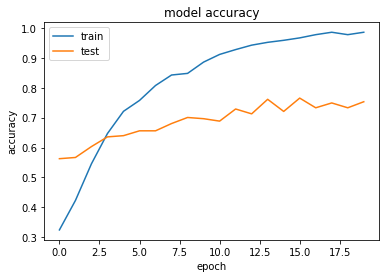

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

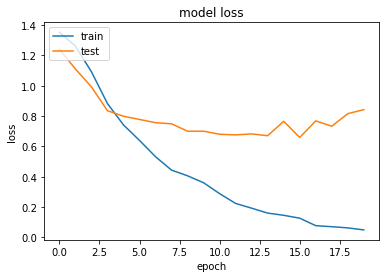

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [44]:
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix
confusion_matrix = multilabel_confusion_matrix(actual, predict_vgg16, labels=action_values)

print(confusion_matrix)

[[[60  1]
  [ 3 17]]

 [[59  2]
  [ 2 18]]

 [[58  3]
  [ 1 19]]

 [[59  1]
  [ 1 20]]]


In [45]:
def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=30):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

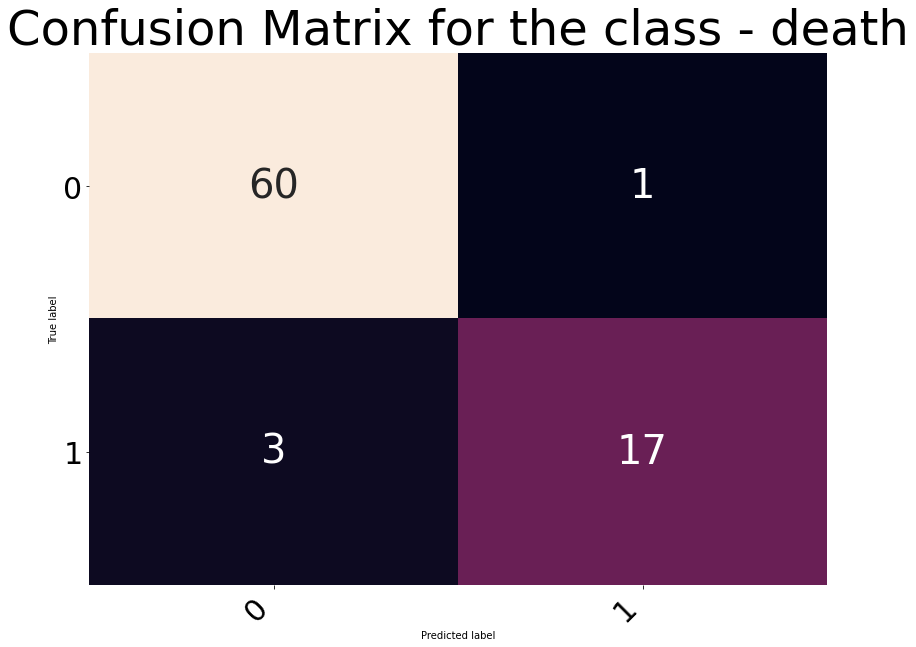

In [46]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[0], ax, action_values[0], ["0", "1"])
fig.tight_layout()
plt.show()

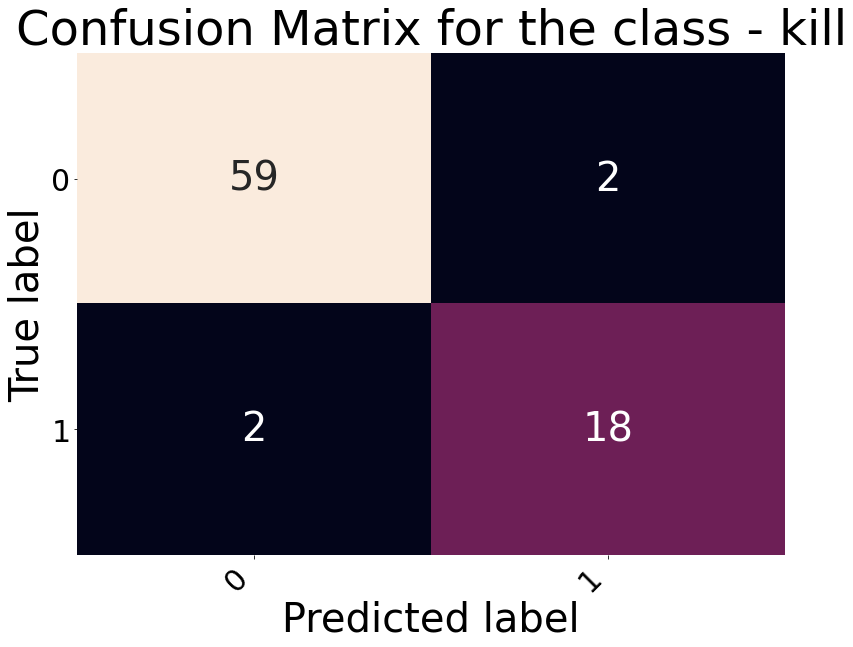

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[1], ax, action_values[1], ["0", "1"])
fig.tight_layout()
plt.show()

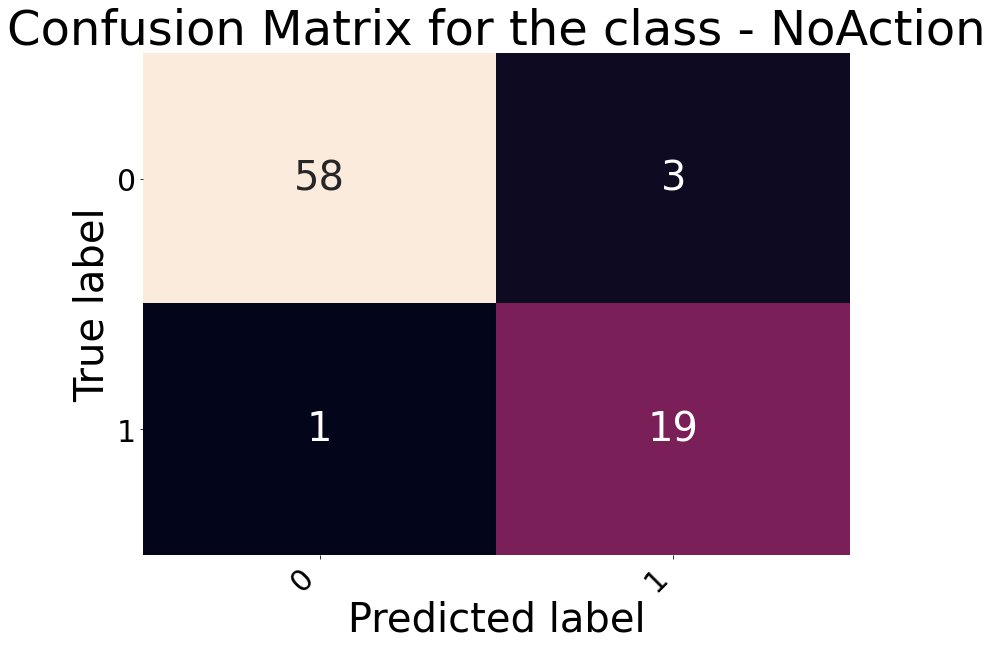

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[2], ax, action_values[2], ["0", "1"])
fig.tight_layout()
plt.show()

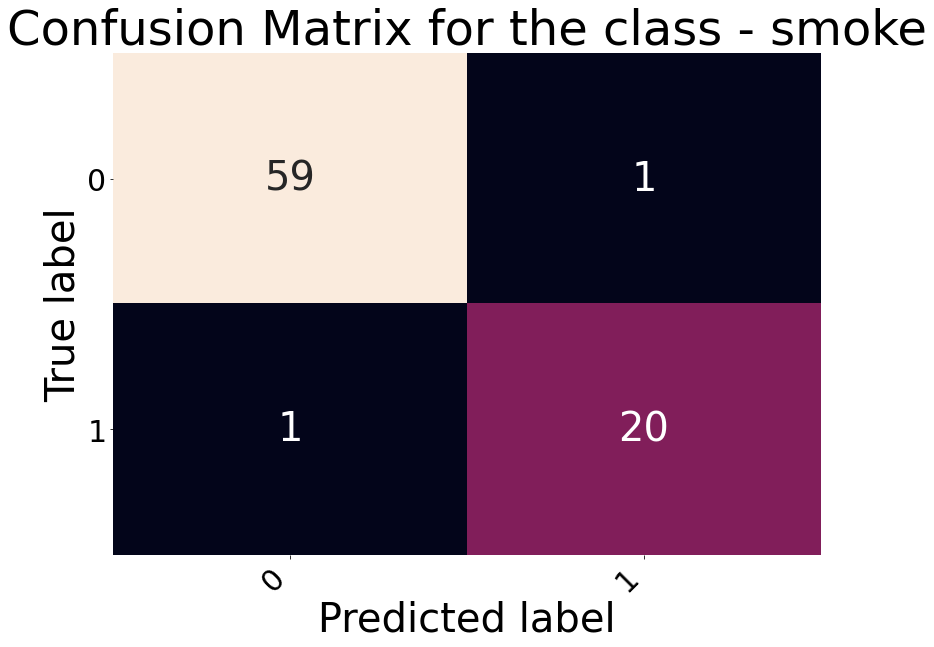

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[3], ax, action_values[3], ["0", "1"])
fig.tight_layout()
plt.show()

# Xception

In [56]:
X_train = X_train_set_copy
X_val = X_val_set_copy

print(X_train.shape)
print(X_val.shape)

(742, 224, 224, 3)
(247, 224, 224, 3)


In [57]:
from tensorflow.keras.applications.xception import Xception
'''This model was trained on a dataset that has 1,000 classes. 
include_top = False will remove the last layer of this model so that we can tune it as per our need.
'''
base_model_xception = Xception(weights='imagenet', include_top=False)

In [58]:
X_train = base_model_xception.predict(X_train)
X_train.shape

(742, 7, 7, 2048)

In [59]:
X_val = base_model_xception.predict(X_val)
X_val.shape

(247, 7, 7, 2048)

In [60]:
#'warning'
X_train_copy_xception = X_train
X_val_copy_xception = X_val

In [302]:
X_train = X_train_copy_xception
X_val = X_val_copy_xception

In [61]:
X_train = X_train.reshape(X_train.shape[0], 7*7*2048)
X_val = X_val.reshape(X_val.shape[0], 7*7*2048)

max_pixel = X_train.max()
X_train = X_train / max_pixel
X_val = X_val / max_pixel
print(X_train.shape)
print(X_val.shape)

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(100352,)))
model.add(Dropout(0.5))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
#model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
#model.summary()
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint(
   'weight_vgg16_final3_1.hdf5', 
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.002)
metrics = ['accuracy',
                tf.keras.metrics.AUC(),
                tfa.metrics.CohenKappa(num_classes = 4),
                tfa.metrics.F1Score(num_classes = 4),
                tf.keras.metrics.Precision(), 
                tf.keras.metrics.Recall()]

callbacks = [earlystop, checkpoint, learning_rate_reduction]

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = metrics)
model.summary()
#from keras.callbacks import ModelCheckpoint
#mcp_weight = ModelCheckpoint('weight_xception_final1_4.hdf5', save_best_only=True, monitor='val_loss', mode='min')

history_xception=model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=callbacks, batch_size=150)

(742, 100352)
(247, 100352)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               51380736  
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)           

5/5 [==============================] - 3s 573ms/step - loss: 0.1885 - accuracy: 0.9308 - auc_4: 0.9026 - cohen_kappa: 0.5892 - f1_score: 0.6778 - precision_1: 0.7997 - recall_1: 0.6194 - val_loss: 0.9193 - val_accuracy: 0.6761 - val_auc_4: 0.9056 - val_cohen_kappa: 0.5961 - val_f1_score: 0.6832 - val_precision_1: 0.8027 - val_recall_1: 0.6265

Epoch 00017: val_loss did not improve from 0.81591
Epoch 18/20
5/5 [==============================] - 3s 551ms/step - loss: 0.1475 - accuracy: 0.9581 - auc_4: 0.9084 - cohen_kappa: 0.6028 - f1_score: 0.6884 - precision_1: 0.8066 - recall_1: 0.6328 - val_loss: 0.9603 - val_accuracy: 0.6964 - val_auc_4: 0.9113 - val_cohen_kappa: 0.6105 - val_f1_score: 0.6945 - val_precision_1: 0.8101 - val_recall_1: 0.6401
Restoring model weights from the end of the best epoch.

Epoch 00018: val_loss did not improve from 0.81591
Epoch 00018: early stopping


In [62]:
from scipy import stats as s
predict_xception = []
actual = []
dict_xception = {}

if not os.path.exists(test_frames_path):
    os.makedirs(test_frames_path)

for i in tqdm(range(test.shape[0])):
    video_file = test['Video_url'][i]
    action = test['action'][i]
    video_name_list = video_file.split('/')[-1].split('.')
    video_name_list = video_name_list[:-1]
    video_name = ""
    for n in video_name_list:
        video_name += n
    # capturing the video from the given path
    capture = cv2.VideoCapture(video_file) 
    #frame rate
    frame_rate = capture.get(5)
    count = 0
    files = glob(test_frames_path + '/*')
    #removing all files from folder
    for f in files:
        os.remove(f)
    while(capture.isOpened()):
        #current frame number
        frame_id = capture.get(1) 
        read_correctly, frame = capture.read()
        if not read_correctly:
            break
        if (frame_id % math.floor(frame_rate) == 0):
            # storing the frames in a new folder named train_1
            filename = test_frames_path + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
            count += 1
            cv2.imwrite(filename, frame)
    capture.release()
    
    # reading all the frames from temp folder
    images = glob(test_frames_path + '/*.jpg')
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img / 255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    #prediction_images = prediction_images / max_pixel
    # extracting features using pre-trained model
    prediction_images = base_model_xception.predict(prediction_images)
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*2048)
    # predicting tags for each array
    prediction = np.argmax(model.predict(prediction_images), axis=-1)
    
    prediction_test = y_train.columns.values[s.mode(prediction)[0][0]]
    if prediction_test != action:
        dict_xception[video_name] = prediction_test
        
    # appending the mode of predictions in predict list to assign the tag to the video
    predict_xception.append(y_train.columns.values[s.mode(prediction)[0][0]])
    # appending the actual tag of the video
    actual.append(action)

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [02:04<00:00,  1.53s/it]


In [63]:
from sklearn.metrics import accuracy_score
accuracy_score(predict_xception, actual)*100

86.41975308641975

In [64]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

accuracy = accuracy_score(predict_xception, actual)*100
precision = precision_score(actual, predict_xception, average=None)
f1_score = f1_score(actual, predict_xception, average=None)
recall = recall_score(actual, predict_xception, average=None)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1_score: ', f1_score)
print('Recall: ', recall)

Accuracy:  86.41975308641975
Precision:  [1.         0.84210526 0.7826087  0.86956522]
F1_score:  [0.88888889 0.82051282 0.8372093  0.90909091]
Recall:  [0.8        0.8        0.9        0.95238095]


In [65]:
print(dict_xception)
print(dict_vgg16)
#print(dict_inceptionv3)
#print(dict_inceptionresnetv2)

{'death_17': 'kill', 'Kill_4': 'smoke', 'NoAction_102': 'kill', 'NoAction_9': 'kill', 'NoAction_96': 'death', 'death_102': 'kill', 'death_55': 'smoke', 'NoAction_77': 'death', 'death_16': 'kill', 'Kill_89': 'smoke', 'smoke_7 ': 'death'}
{'Kill_4': 'death', 'death_33': 'NoAction', 'NoAction_9': 'smoke', 'smoke_10 ': 'death', 'death_16': 'kill', 'Kill_89': 'death', 'smoke_7 ': 'death', 'Kill_51': 'death'}


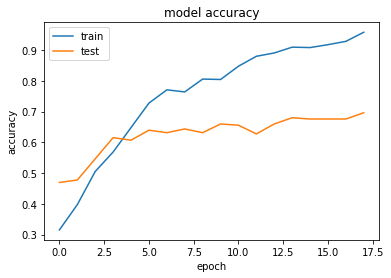

In [66]:
plt.plot(history_xception.history['accuracy'])
plt.plot(history_xception.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

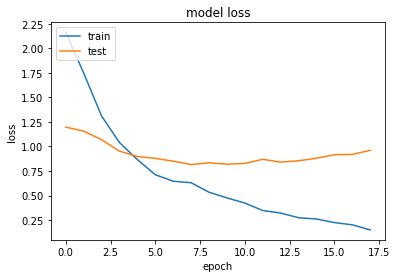

In [67]:
plt.plot(history_xception.history['loss'])
plt.plot(history_xception.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [68]:
confusion_matrix = multilabel_confusion_matrix(actual, predict_xception, labels=action_values)

print(confusion_matrix)

NameError: name 'multilabel_confusion_matrix' is not defined

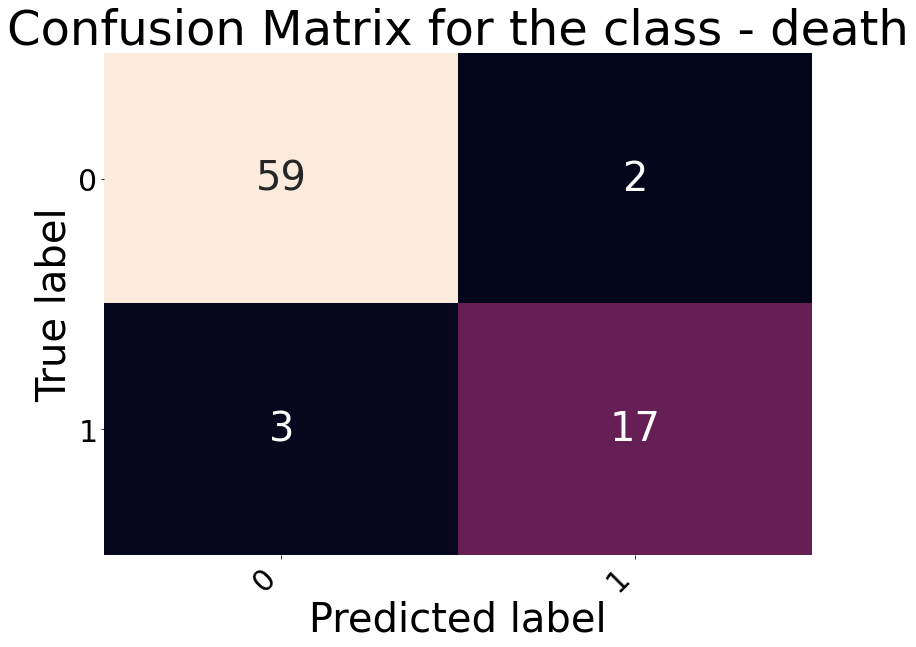

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[0], ax, action_values[0], ["0", "1"])
fig.tight_layout()
plt.show()

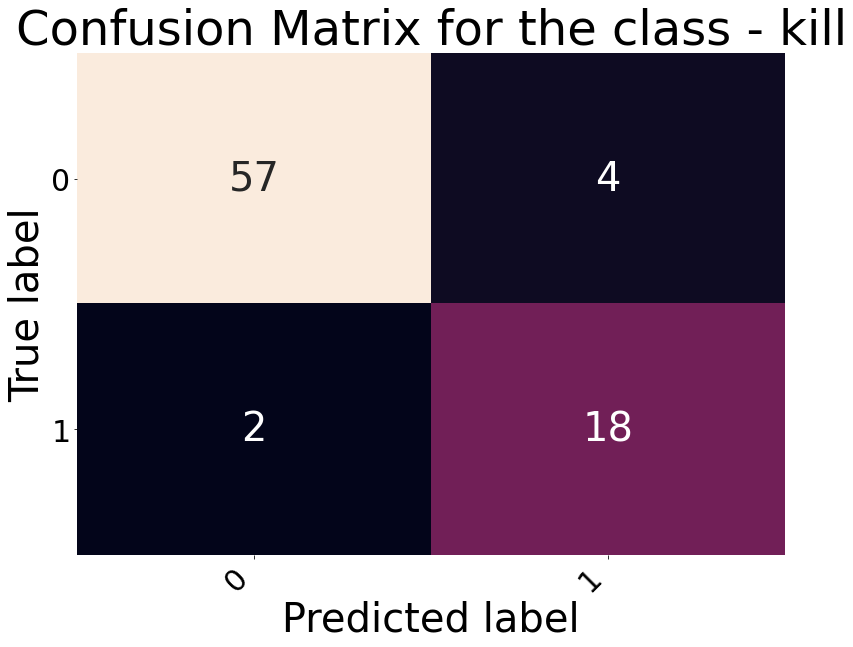

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[1], ax, action_values[1], ["0", "1"])
fig.tight_layout()
plt.show()

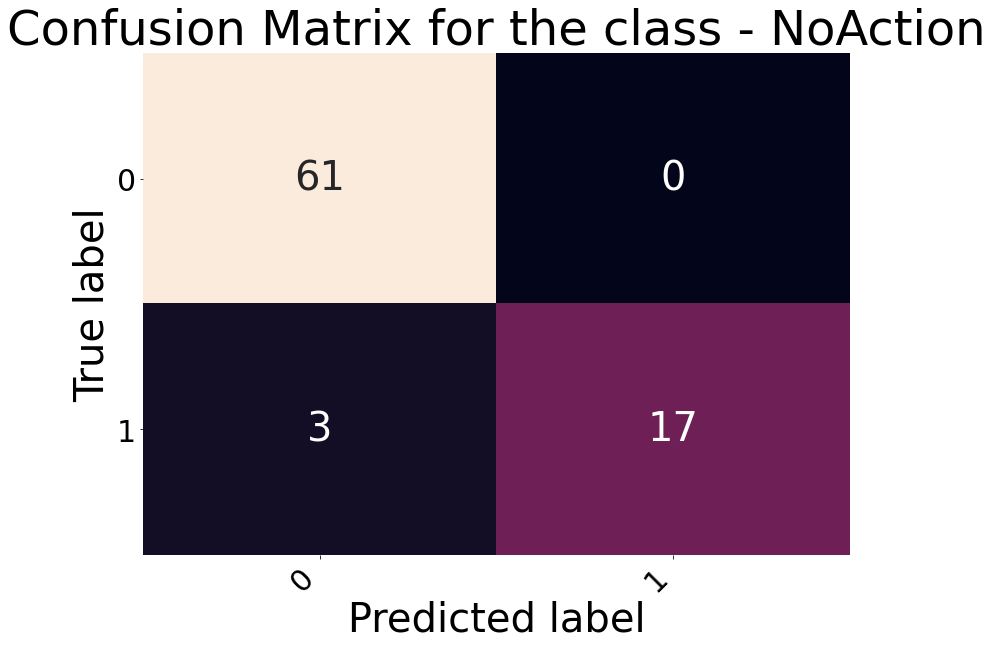

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[2], ax, action_values[2], ["0", "1"])
fig.tight_layout()
plt.show()

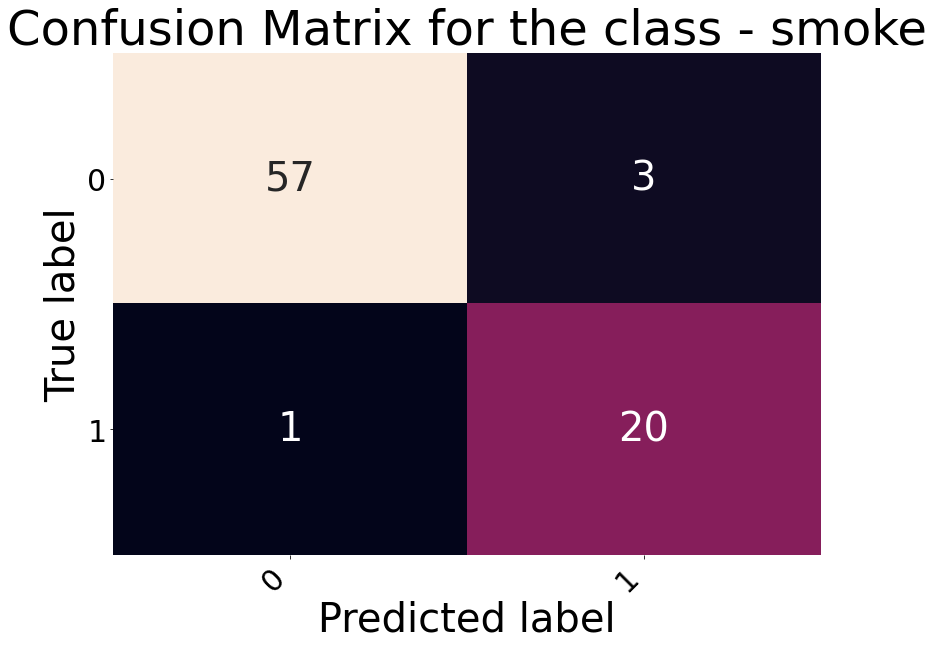

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[3], ax, action_values[3], ["0", "1"])
fig.tight_layout()
plt.show()

# InceptionV3


In [69]:
X_train = X_train_set_copy
X_val = X_val_set_copy

print(X_train.shape)
print(X_val.shape)

(742, 224, 224, 3)
(247, 224, 224, 3)


In [70]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
'''This model was trained on a dataset that has 1,000 classes. 
include_top = False will remove the last layer of this model so that we can tune it as per our need.
'''
base_model_inception = InceptionV3(weights='imagenet', include_top=False)

In [71]:
X_train = base_model_inception.predict(X_train)
X_val = base_model_inception.predict(X_val)
X_val.shape

print(X_train.shape)
print(X_val.shape)

(742, 5, 5, 2048)
(247, 5, 5, 2048)


In [72]:
#'warning'
X_train_copy_inception = X_train
X_val_copy_inception = X_val

In [309]:
X_train = X_train_copy_inception
X_val = X_val_copy_inception

In [73]:
X_train = X_train.reshape(X_train.shape[0], 5*5*2048)
X_val = X_val.reshape(X_val.shape[0], 5*5*2048)

max_pixel = X_train.max()
X_train = X_train / max_pixel
X_val = X_val / max_pixel
print(X_train.shape)
print(X_val.shape)

model = Sequential()
model.add(Dense(1024, activation='relu', input_shape=(51200,)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
#model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
#model.summary()

#from keras.callbacks import ModelCheckpoint
#mcp_weight = ModelCheckpoint('weight_inception_final1_4.hdf5', save_best_only=True, monitor='val_loss', mode='min')

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint(
   'weight_vgg16_final3_1.hdf5', 
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.002)
metrics = ['accuracy',
                tf.keras.metrics.AUC(),
                tfa.metrics.CohenKappa(num_classes = 4),
                tfa.metrics.F1Score(num_classes = 4),
                tf.keras.metrics.Precision(), 
                tf.keras.metrics.Recall()]

callbacks = [earlystop, checkpoint, learning_rate_reduction]

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = metrics)
model.summary()
#from keras.callbacks import ModelCheckpoint
#mcp_weight = ModelCheckpoint('weight_xception_final1_4.hdf5', save_best_only=True, monitor='val_loss', mode='min')


history_inception=model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=callbacks, batch_size=150)

(742, 51200)
(247, 51200)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1024)              52429824  
_________________________________________________________________
dropout_6 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_7 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)            

5/5 [==============================] - 3s 648ms/step - loss: 0.2987 - accuracy: 0.8929 - auc_5: 0.8694 - cohen_kappa: 0.5083 - f1_score: 0.5998 - precision_2: 0.7810 - recall_2: 0.5107 - val_loss: 0.8118 - val_accuracy: 0.7449 - val_auc_5: 0.8748 - val_cohen_kappa: 0.5197 - val_f1_score: 0.6088 - val_precision_2: 0.7867 - val_recall_2: 0.5232

Epoch 00016: val_loss did not improve from 0.75728
Epoch 17/20
5/5 [==============================] - 3s 574ms/step - loss: 0.2198 - accuracy: 0.9169 - auc_5: 0.8789 - cohen_kappa: 0.5277 - f1_score: 0.6149 - precision_2: 0.7913 - recall_2: 0.5316 - val_loss: 0.8502 - val_accuracy: 0.7530 - val_auc_5: 0.8836 - val_cohen_kappa: 0.5382 - val_f1_score: 0.6233 - val_precision_2: 0.7953 - val_recall_2: 0.5427

Epoch 00017: val_loss did not improve from 0.75728
Epoch 18/20
5/5 [==============================] - 3s 546ms/step - loss: 0.1924 - accuracy: 0.9247 - auc_5: 0.8871 - cohen_kappa: 0.5454 - f1_score: 0.6289 - precision_2: 0.7992 - recall_2: 0.55

In [74]:
from scipy import stats as s
predict_inception = []
actual = []
dict_inceptionv3 = {}

if not os.path.exists(test_frames_path):
    os.makedirs(test_frames_path)

for i in tqdm(range(test.shape[0])):
    video_file = test['Video_url'][i]
    action = test['action'][i]
    video_name_list = video_file.split('/')[-1].split('.')
    video_name_list = video_name_list[:-1]
    video_name = ""
    for n in video_name_list:
        video_name += n
    # capturing the video from the given path
    capture = cv2.VideoCapture(video_file) 
    #frame rate
    frame_rate = capture.get(5)
    count = 0
    files = glob(test_frames_path + '/*')
    #removing all files from folder
    for f in files:
        os.remove(f)
    while(capture.isOpened()):
        #current frame number
        frame_id = capture.get(1) 
        read_correctly, frame = capture.read()
        if not read_correctly:
            break
        if (frame_id % math.floor(frame_rate) == 0):
            # storing the frames in a new folder named train_1
            filename = test_frames_path + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
            count += 1
            cv2.imwrite(filename, frame)
    capture.release()
    
    # reading all the frames from temp folder
    images = glob(test_frames_path + '/*.jpg')
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img / 255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    #prediction_images = prediction_images / max_pixel
    # extracting features using pre-trained model
    prediction_images = base_model_inception.predict(prediction_images)
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 5*5*2048)
    # predicting tags for each array
    prediction = np.argmax(model.predict(prediction_images), axis=-1)
    # appending the mode of predictions in predict list to assign the tag to the video
    
    prediction_test = y_train.columns.values[s.mode(prediction)[0][0]]
    if prediction_test != action:
        dict_inceptionv3[video_name] = prediction_test
    
    predict_inception.append(y_train.columns.values[s.mode(prediction)[0][0]])
    # appending the actual tag of the video
    actual.append(action)

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [01:37<00:00,  1.21s/it]


In [75]:
from sklearn.metrics import accuracy_score
accuracy_score(predict_inception, actual)*100

90.12345679012346

In [76]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

accuracy = accuracy_score(predict_inception, actual)*100
precision = precision_score(actual, predict_inception, average=None)
f1_score = f1_score(actual, predict_inception, average=None)
recall = recall_score(actual, predict_inception, average=None)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1_score: ', f1_score)
print('Recall: ', recall)

Accuracy:  90.12345679012346
Precision:  [0.9047619  0.89473684 0.94444444 0.86956522]
F1_score:  [0.92682927 0.87179487 0.89473684 0.90909091]
Recall:  [0.95       0.85       0.85       0.95238095]


In [77]:
print(dict_vgg16)
print(dict_xception)
print(dict_inceptionv3)

{'Kill_4': 'death', 'death_33': 'NoAction', 'NoAction_9': 'smoke', 'smoke_10 ': 'death', 'death_16': 'kill', 'Kill_89': 'death', 'smoke_7 ': 'death', 'Kill_51': 'death'}
{'death_17': 'kill', 'Kill_4': 'smoke', 'NoAction_102': 'kill', 'NoAction_9': 'kill', 'NoAction_96': 'death', 'death_102': 'kill', 'death_55': 'smoke', 'NoAction_77': 'death', 'death_16': 'kill', 'Kill_89': 'smoke', 'smoke_7 ': 'death'}
{'death_17': 'kill', 'Kill_4': 'smoke', 'death_45': 'NoAction', 'death_42': 'smoke', 'NoAction_9': 'smoke', 'Kill_22': 'death', 'Kill_89': 'NoAction', 'smoke_7 ': 'death'}


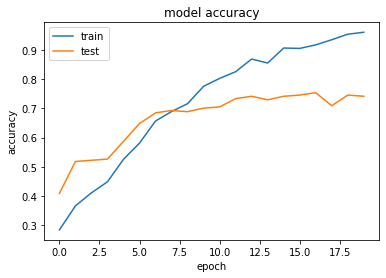

In [78]:
plt.plot(history_inception.history['accuracy'])
plt.plot(history_inception.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

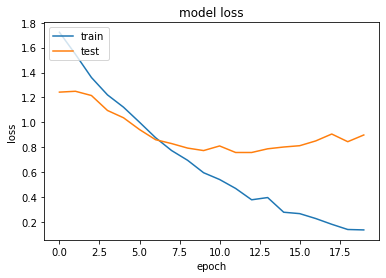

In [79]:
plt.plot(history_inception.history['loss'])
plt.plot(history_inception.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.load_weights("weight_inception_final1_3.hdf5")
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
model.summary()

In [78]:
confusion_matrix = multilabel_confusion_matrix(actual, predict_inception, labels=action_values)

print(confusion_matrix)

[[[59  2]
  [ 2 18]]

 [[59  2]
  [ 2 18]]

 [[60  1]
  [ 3 17]]

 [[57  3]
  [ 1 20]]]


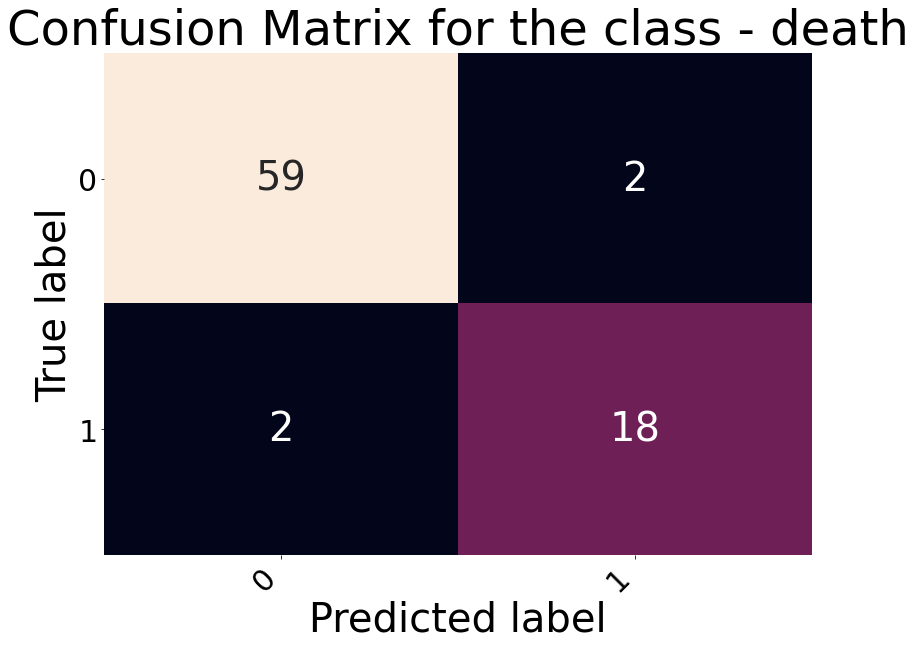

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[0], ax, action_values[0], ["0", "1"])
fig.tight_layout()
plt.show()

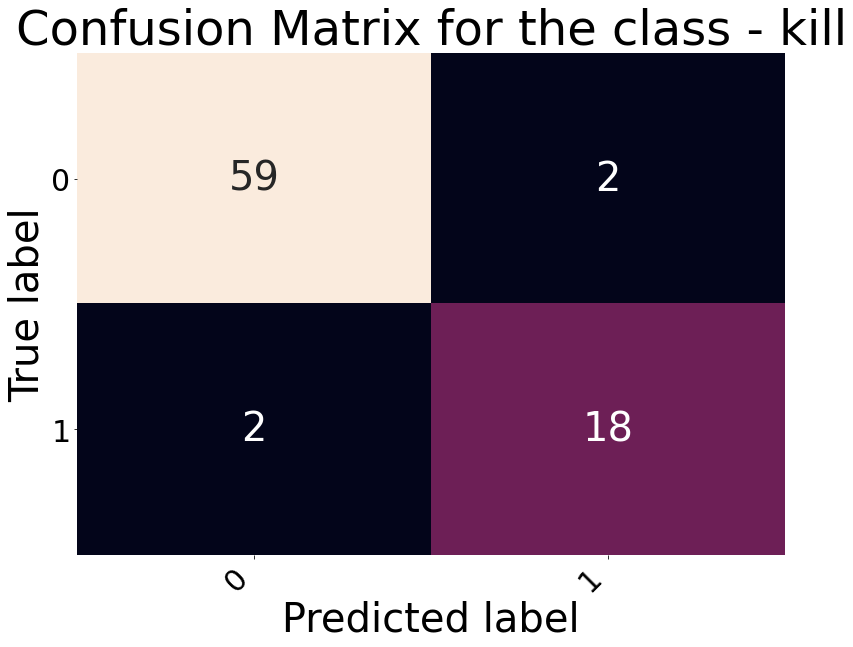

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[1], ax, action_values[1], ["0", "1"])
fig.tight_layout()
plt.show()

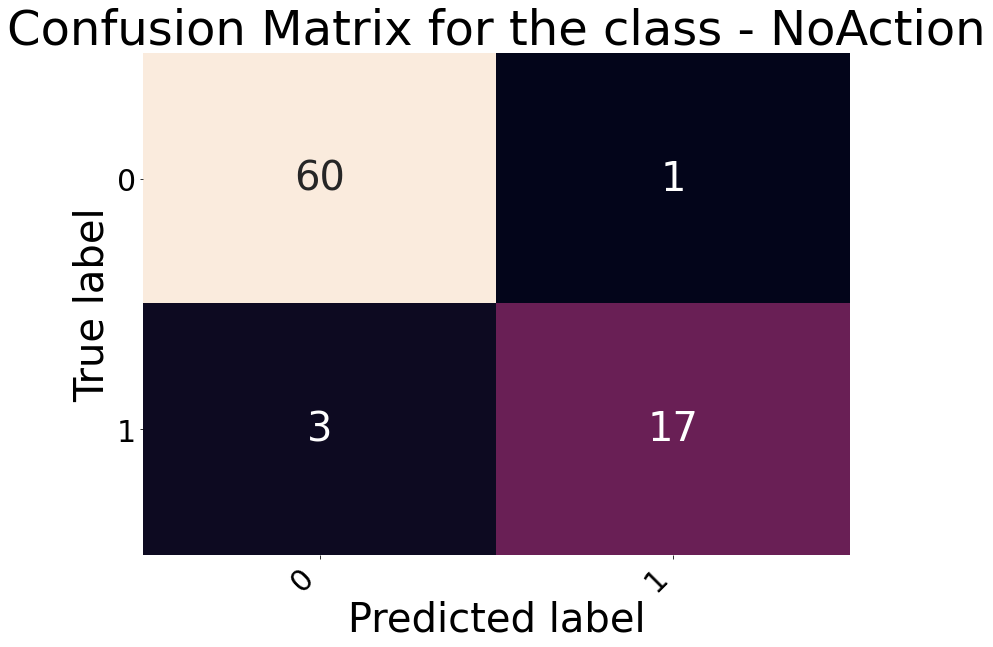

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[2], ax, action_values[2], ["0", "1"])
fig.tight_layout()
plt.show()

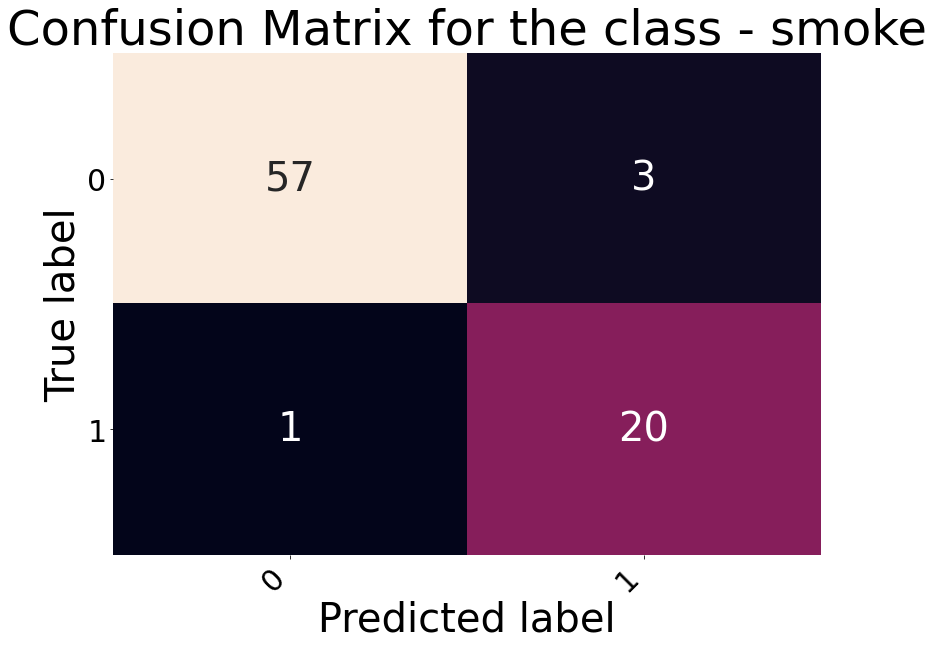

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[3], ax, action_values[3], ["0", "1"])
fig.tight_layout()
plt.show()

# InceptionResnetV2

In [80]:
X_train = X_train_set_copy
X_val = X_val_set_copy

print(X_train.shape)
print(X_val.shape)

(742, 224, 224, 3)
(247, 224, 224, 3)


In [81]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
'''This model was trained on a dataset that has 1,000 classes. 
include_top = False will remove the last layer of this model so that we can tune it as per our need.
'''
base_model_InceptionResNetV2 = InceptionResNetV2(weights='imagenet', include_top=False)

In [82]:
X_train = base_model_InceptionResNetV2.predict(X_train)
X_val = base_model_InceptionResNetV2.predict(X_val)
X_val.shape

print(X_train.shape)
print(X_val.shape)

(742, 5, 5, 1536)
(247, 5, 5, 1536)


In [83]:
#'warning'
X_train_copy_inceptionresnet = X_train
X_val_copy_inceptionresnet = X_val

In [316]:
X_train = X_train_copy_inceptionresnet
X_val = X_val_copy_inceptionresnet

In [84]:
X_train = X_train.reshape(X_train.shape[0], 5*5*1536)
X_val = X_val.reshape(X_val.shape[0], 5*5*1536)

max_pixel = X_train.max()
X_train = X_train / max_pixel
X_val = X_val / max_pixel
print(X_train.shape)
print(X_val.shape)

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(38400,)))
model.add(Dropout(0.5))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
#model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
#model.summary()

#from keras.callbacks import ModelCheckpoint
#mcp_weight = ModelCheckpoint('weight_inceptionresnet_final1_4.hdf5', save_best_only=True, monitor='val_loss', mode='min')

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint(
   'weight_vgg16_final3_1.hdf5', 
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.002)
metrics = ['accuracy',
                tf.keras.metrics.AUC(),
                tfa.metrics.CohenKappa(num_classes = 4),
                tfa.metrics.F1Score(num_classes = 4),
                tf.keras.metrics.Precision(), 
                tf.keras.metrics.Recall()]

callbacks = [earlystop, checkpoint, learning_rate_reduction]

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = metrics)
model.summary()

history_InceptionResNetV2=model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val), callbacks=callbacks, 
                                    batch_size=150)

(742, 38400)
(247, 38400)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               19661312  
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_11 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_16 (Dense)            

5/5 [==============================] - 1s 217ms/step - loss: 0.0966 - accuracy: 0.9805 - auc_6: 0.9326 - cohen_kappa: 0.6594 - f1_score: 0.7237 - precision_3: 0.8411 - recall_3: 0.6776 - val_loss: 0.8840 - val_accuracy: 0.7328 - val_auc_6: 0.9350 - val_cohen_kappa: 0.6668 - val_f1_score: 0.7296 - val_precision_3: 0.8443 - val_recall_3: 0.6854

Epoch 00017: val_loss did not improve from 0.74133
Epoch 18/30
5/5 [==============================] - 1s 217ms/step - loss: 0.0822 - accuracy: 0.9771 - auc_6: 0.9370 - cohen_kappa: 0.6724 - f1_score: 0.7340 - precision_3: 0.8474 - recall_3: 0.6910 - val_loss: 1.0103 - val_accuracy: 0.7166 - val_auc_6: 0.9386 - val_cohen_kappa: 0.6785 - val_f1_score: 0.7392 - val_precision_3: 0.8496 - val_recall_3: 0.6976

Epoch 00018: val_loss did not improve from 0.74133
Epoch 19/30
5/5 [==============================] - 1s 214ms/step - loss: 0.1021 - accuracy: 0.9758 - auc_6: 0.9404 - cohen_kappa: 0.6837 - f1_score: 0.7435 - precision_3: 0.8523 - recall_3: 0.70

In [85]:
from scipy import stats as s
predict_inceptionresnet = []
actual = []
dict_inceptionresnetv2 = {}

if not os.path.exists(test_frames_path):
    os.makedirs(test_frames_path)

for i in tqdm(range(test.shape[0])):
    video_file = test['Video_url'][i]
    action = test['action'][i]
    video_name_list = video_file.split('/')[-1].split('.')
    video_name_list = video_name_list[:-1]
    video_name = ""
    for n in video_name_list:
        video_name += n
    # capturing the video from the given path
    capture = cv2.VideoCapture(video_file) 
    #frame rate
    frame_rate = capture.get(5)
    count = 0
    files = glob(test_frames_path + '/*')
    #removing all files from folder
    for f in files:
        os.remove(f)
    while(capture.isOpened()):
        #current frame number
        frame_id = capture.get(1) 
        read_correctly, frame = capture.read()
        if not read_correctly:
            break
        if (frame_id % math.floor(frame_rate) == 0):
            # storing the frames in a new folder named train_1
            filename = test_frames_path + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
            count += 1
            cv2.imwrite(filename, frame)
    capture.release()
    
    # reading all the frames from temp folder
    images = glob(test_frames_path + '/*.jpg')
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img / 255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    #prediction_images = prediction_images / max_pixel
    # extracting features using pre-trained model
    prediction_images = base_model_InceptionResNetV2.predict(prediction_images)
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 5*5*1536)
    # predicting tags for each array
    prediction = np.argmax(model.predict(prediction_images), axis=-1)
    # appending the mode of predictions in predict list to assign the tag to the video
    
    prediction_test = y_train.columns.values[s.mode(prediction)[0][0]]
    if prediction_test != action:
        dict_inceptionresnetv2[video_name] = prediction_test
    
    predict_inceptionresnet.append(y_train.columns.values[s.mode(prediction)[0][0]])
    # appending the actual tag of the video
    actual.append(action)

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [01:54<00:00,  1.41s/it]


In [86]:
print(dict_vgg16)
print(dict_xception)
print(dict_inceptionv3)
print(dict_inceptionresnetv2)

{'Kill_4': 'death', 'death_33': 'NoAction', 'NoAction_9': 'smoke', 'smoke_10 ': 'death', 'death_16': 'kill', 'Kill_89': 'death', 'smoke_7 ': 'death', 'Kill_51': 'death'}
{'death_17': 'kill', 'Kill_4': 'smoke', 'NoAction_102': 'kill', 'NoAction_9': 'kill', 'NoAction_96': 'death', 'death_102': 'kill', 'death_55': 'smoke', 'NoAction_77': 'death', 'death_16': 'kill', 'Kill_89': 'smoke', 'smoke_7 ': 'death'}
{'death_17': 'kill', 'Kill_4': 'smoke', 'death_45': 'NoAction', 'death_42': 'smoke', 'NoAction_9': 'smoke', 'Kill_22': 'death', 'Kill_89': 'NoAction', 'smoke_7 ': 'death'}
{'death_17': 'kill', 'Kill_4': 'smoke', 'death_33': 'smoke', 'NoAction_55': 'kill', 'Kill_5': 'NoAction', 'death_42': 'smoke', 'death_102': 'kill', 'smoke_80 ': 'kill', 'death_16': 'kill', 'death_66': 'NoAction'}


In [87]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

accuracy = accuracy_score(predict_inceptionresnet, actual)*100
precision = precision_score(actual, predict_inceptionresnet, average=None)
f1_score = f1_score(actual, predict_inceptionresnet, average=None)
recall = recall_score(actual, predict_inceptionresnet, average=None)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1_score: ', f1_score)
print('Recall: ', recall)

Accuracy:  87.65432098765432
Precision:  [0.9047619  1.         0.7826087  0.86956522]
F1_score:  [0.92682927 0.82352941 0.8372093  0.90909091]
Recall:  [0.95       0.7        0.9        0.95238095]


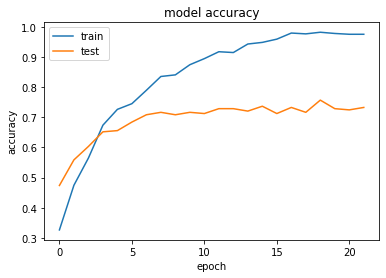

In [88]:
plt.plot(history_InceptionResNetV2.history['accuracy'])
plt.plot(history_InceptionResNetV2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

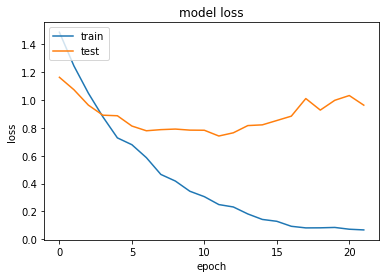

In [89]:
plt.plot(history_InceptionResNetV2.history['loss'])
plt.plot(history_InceptionResNetV2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [93]:
confusion_matrix = multilabel_confusion_matrix(actual, predict_inceptionresnet, labels=action_values)

print(confusion_matrix)

[[[61  0]
  [ 7 13]]

 [[54  7]
  [ 2 18]]

 [[58  3]
  [ 1 19]]

 [[57  3]
  [ 3 18]]]


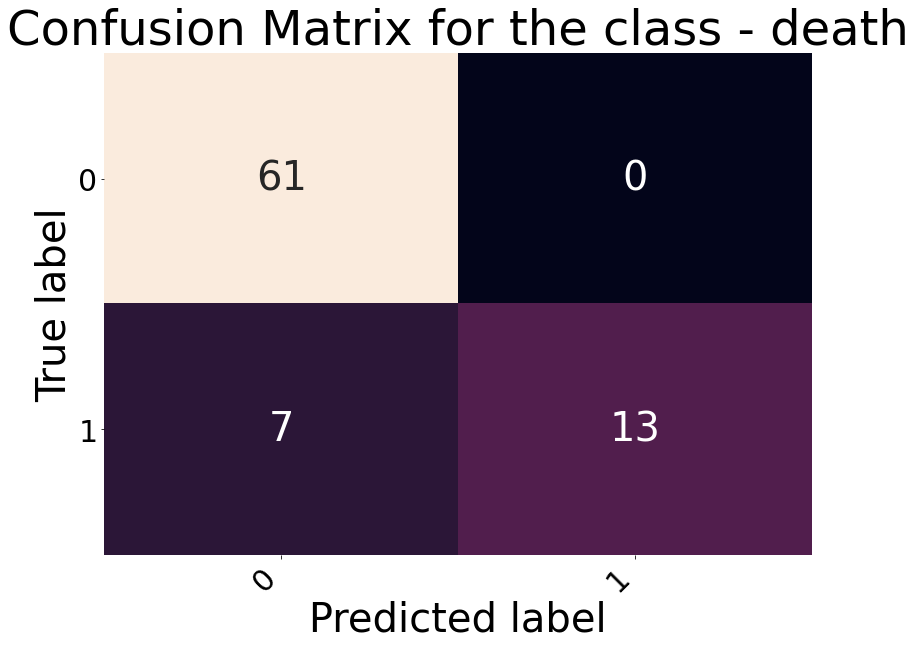

In [94]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[0], ax, action_values[0], ["0", "1"])
fig.tight_layout()
plt.show()

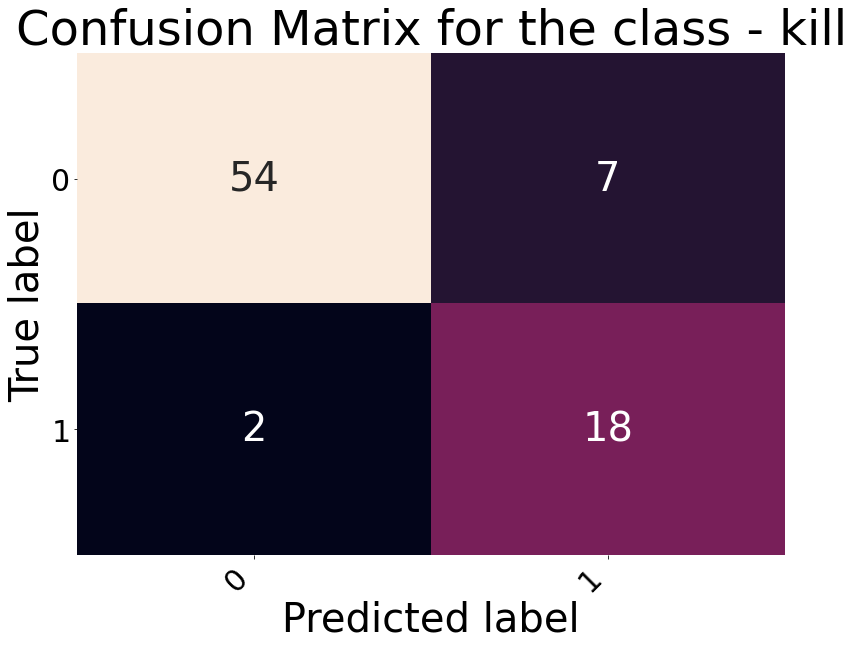

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[1], ax, action_values[1], ["0", "1"])
fig.tight_layout()
plt.show()

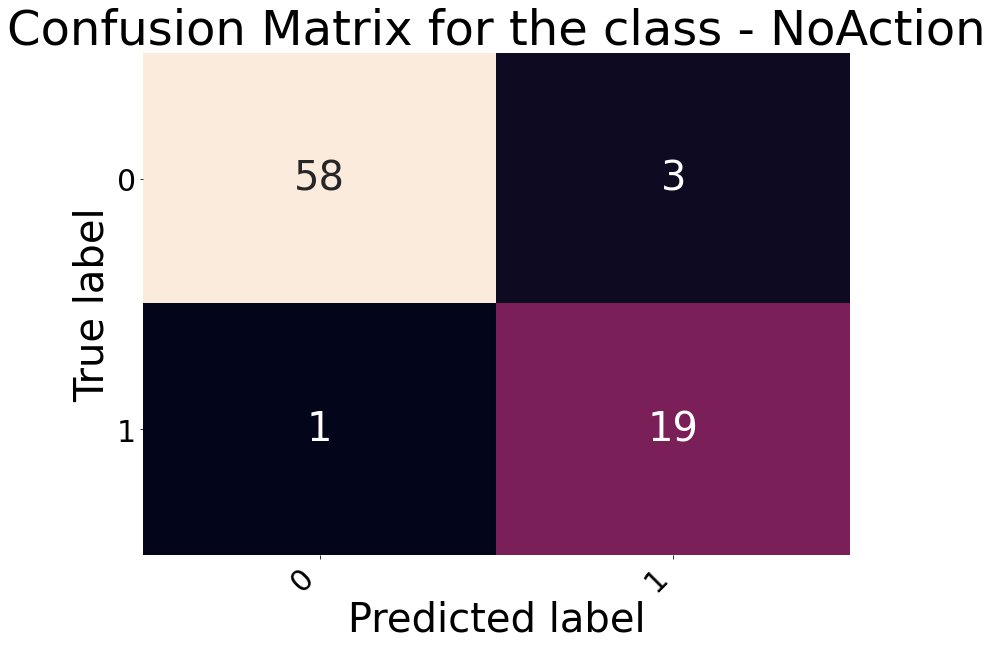

In [96]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[2], ax, action_values[2], ["0", "1"])
fig.tight_layout()
plt.show()

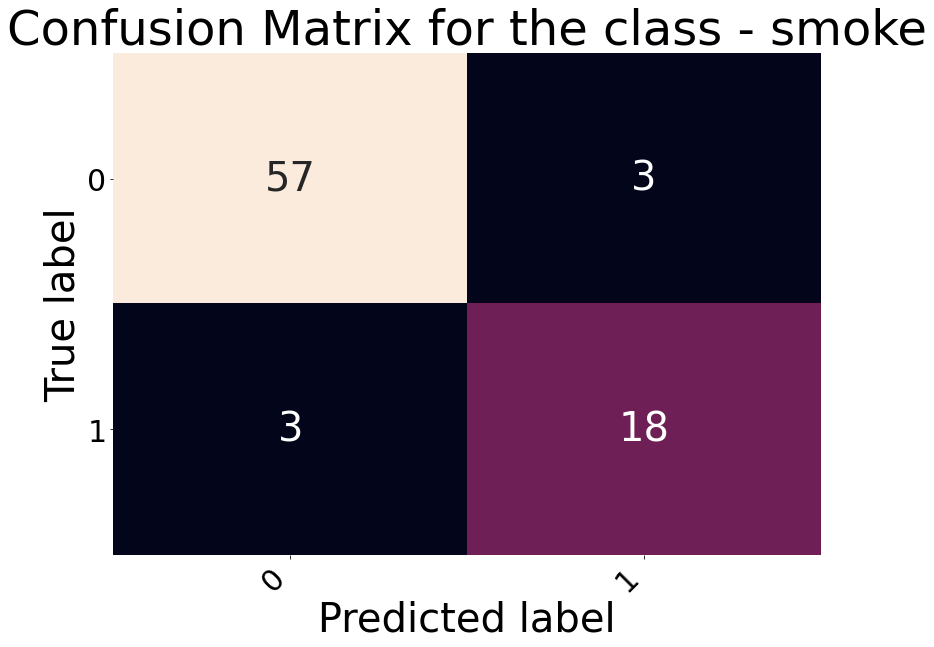

In [97]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[3], ax, action_values[3], ["0", "1"])
fig.tight_layout()
plt.show()

# Resnet152vV2


In [90]:
X_train = X_train_set_copy
X_val = X_val_set_copy

print(X_train.shape)
print(X_val.shape)

(742, 224, 224, 3)
(247, 224, 224, 3)


In [91]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
'''This model was trained on a dataset that has 1,000 classes. 
include_top = False will remove the last layer of thresnet_v2is model so that we can tune it as per our need.
'''
base_model_resnet_v2 = ResNet152V2(weights='imagenet', include_top=False)

In [92]:
X_train = base_model_resnet_v2.predict(X_train)
X_val = base_model_resnet_v2.predict(X_val)

print(X_train.shape)
print(X_val.shape)

(742, 7, 7, 2048)
(247, 7, 7, 2048)


In [93]:
#'warning'
X_train_copy_ResNet152V2 = X_train
X_val_copy_ResNet152V2 = X_val

In [323]:
X_train = X_train_copy_ResNet152V2
X_val = X_val_copy_ResNet152V2

In [94]:
X_train = X_train.reshape(X_train.shape[0], 7*7*2048)
X_val = X_val.reshape(X_val.shape[0], 7*7*2048)

max_pixel = X_train.max()
X_train = X_train / max_pixel
X_val = X_val / max_pixel
print(X_train.shape)
print(X_val.shape)

model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(100352,)))
model.add(Dropout(0.5))
#model.add(Dense(512, activation='relu'))
#model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(64, activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))
#model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
#model.summary()

#from keras.callbacks import ModelCheckpoint
#mcp_weight = ModelCheckpoint('weight_X_val_copy_ResNet152V2_final1_2.hdf5', save_best_only=True, monitor='val_loss', 
                             #mode='min')

from keras.callbacks import ModelCheckpoint
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint(
   'weight_vgg16_final3_1.hdf5', 
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1)

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=5,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.002)
metrics = ['accuracy',
                tf.keras.metrics.AUC(),
                tfa.metrics.CohenKappa(num_classes = 4),
                tfa.metrics.F1Score(num_classes = 4),
                tf.keras.metrics.Precision(), 
                tf.keras.metrics.Recall()]

callbacks = [earlystop, checkpoint, learning_rate_reduction]

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = metrics)
model.summary()
    
history_resnet_v2=model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val), callbacks=callbacks, batch_size=150)

(742, 100352)
(247, 100352)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 512)               51380736  
_________________________________________________________________
dropout_13 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_15 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_20 (Dense)          

In [95]:
from scipy import stats as s
predict_resnet = []
actual = []
dict_ResNet152V2 = {}

if not os.path.exists(test_frames_path):
    os.makedirs(test_frames_path)

for i in tqdm(range(test.shape[0])):
    video_file = test['Video_url'][i]
    action = test['action'][i]
    video_name_list = video_file.split('/')[-1].split('.')
    video_name_list = video_name_list[:-1]
    video_name = ""
    for n in video_name_list:
        video_name += n
    # capturing the video from the given path
    capture = cv2.VideoCapture(video_file) 
    #frame rate
    frame_rate = capture.get(5)
    count = 0
    files = glob(test_frames_path + '/*')
    #removing all files from folder
    for f in files:
        os.remove(f)
    while(capture.isOpened()):
        #current frame number
        frame_id = capture.get(1) 
        read_correctly, frame = capture.read()
        if not read_correctly:
            break
        if (frame_id % math.floor(frame_rate) == 0):
            # storing the frames in a new folder named train_1
            filename = test_frames_path + "/" + video_name + "_frame{}_".format(count) + action +".jpg"
            count += 1
            cv2.imwrite(filename, frame)
    capture.release()
    
    # reading all the frames from temp folder
    images = glob(test_frames_path + '/*.jpg')
    prediction_images = []
    for i in range(len(images)):
        img = image.load_img(images[i], target_size=(224,224,3))
        img = image.img_to_array(img)
        img = img / 255
        prediction_images.append(img)
        
    # converting all the frames for a test video into numpy array
    prediction_images = np.array(prediction_images)
    #prediction_images = prediction_images / max_pixel
    # extracting features using pre-trained model
    prediction_images = base_model_resnet_v2.predict(prediction_images)
    # converting features in one dimensional array
    prediction_images = prediction_images.reshape(prediction_images.shape[0], 7*7*2048)
    # predicting tags for each array
    prediction = np.argmax(model.predict(prediction_images), axis=-1)
    
    prediction_test = y_train.columns.values[s.mode(prediction)[0][0]]
    if prediction_test != action:
        dict_ResNet152V2[video_name] = prediction_test
        
    # appending the mode of predictions in predict list to assign the tag to the video
    predict_resnet.append(y_train.columns.values[s.mode(prediction)[0][0]])
    # appending the actual tag of the video
    actual.append(action)

100%|██████████████████████████████████████████████████████████████████████████████████| 81/81 [02:50<00:00,  2.10s/it]


In [96]:
from sklearn.metrics import accuracy_score
accuracy_score(predict_resnet, actual)*100

88.88888888888889

In [97]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

accuracy = accuracy_score(predict_resnet, actual)*100
precision = precision_score(actual, predict_resnet, average=None)
f1_score = f1_score(actual, predict_resnet, average=None)
recall = recall_score(actual, predict_resnet, average=None)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1_score: ', f1_score)
print('Recall: ', recall)

Accuracy:  88.88888888888889
Precision:  [0.95       0.84210526 0.82608696 0.94736842]
F1_score:  [0.95       0.82051282 0.88372093 0.9       ]
Recall:  [0.95       0.8        0.95       0.85714286]


In [98]:
print(dict_vgg16)
print(dict_xception)
print(dict_inceptionv3)
print(dict_inceptionresnetv2)
print(dict_ResNet152V2)

{'Kill_4': 'death', 'death_33': 'NoAction', 'NoAction_9': 'smoke', 'smoke_10 ': 'death', 'death_16': 'kill', 'Kill_89': 'death', 'smoke_7 ': 'death', 'Kill_51': 'death'}
{'death_17': 'kill', 'Kill_4': 'smoke', 'NoAction_102': 'kill', 'NoAction_9': 'kill', 'NoAction_96': 'death', 'death_102': 'kill', 'death_55': 'smoke', 'NoAction_77': 'death', 'death_16': 'kill', 'Kill_89': 'smoke', 'smoke_7 ': 'death'}
{'death_17': 'kill', 'Kill_4': 'smoke', 'death_45': 'NoAction', 'death_42': 'smoke', 'NoAction_9': 'smoke', 'Kill_22': 'death', 'Kill_89': 'NoAction', 'smoke_7 ': 'death'}
{'death_17': 'kill', 'Kill_4': 'smoke', 'death_33': 'smoke', 'NoAction_55': 'kill', 'Kill_5': 'NoAction', 'death_42': 'smoke', 'death_102': 'kill', 'smoke_80 ': 'kill', 'death_16': 'kill', 'death_66': 'NoAction'}
{'death_17': 'kill', 'Kill_4': 'NoAction', 'death_33': 'kill', 'NoAction_9': 'smoke', 'death_102': 'kill', 'smoke_35 ': 'death', 'smoke_10 ': 'death', 'death_16': 'kill', 'smoke_7 ': 'death'}


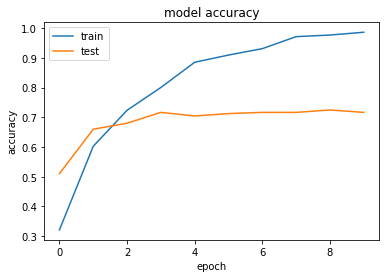

In [99]:
plt.plot(history_resnet_v2.history['accuracy'])
plt.plot(history_resnet_v2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

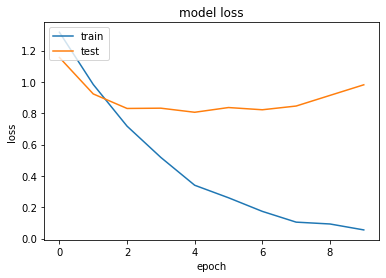

In [100]:
plt.plot(history_resnet_v2.history['loss'])
plt.plot(history_resnet_v2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [109]:
confusion_matrix = multilabel_confusion_matrix(actual, predict_resnet, labels=action_values)

print(confusion_matrix)

[[[60  1]
  [ 2 18]]

 [[59  2]
  [ 1 19]]

 [[61  0]
  [ 1 19]]

 [[59  1]
  [ 0 21]]]


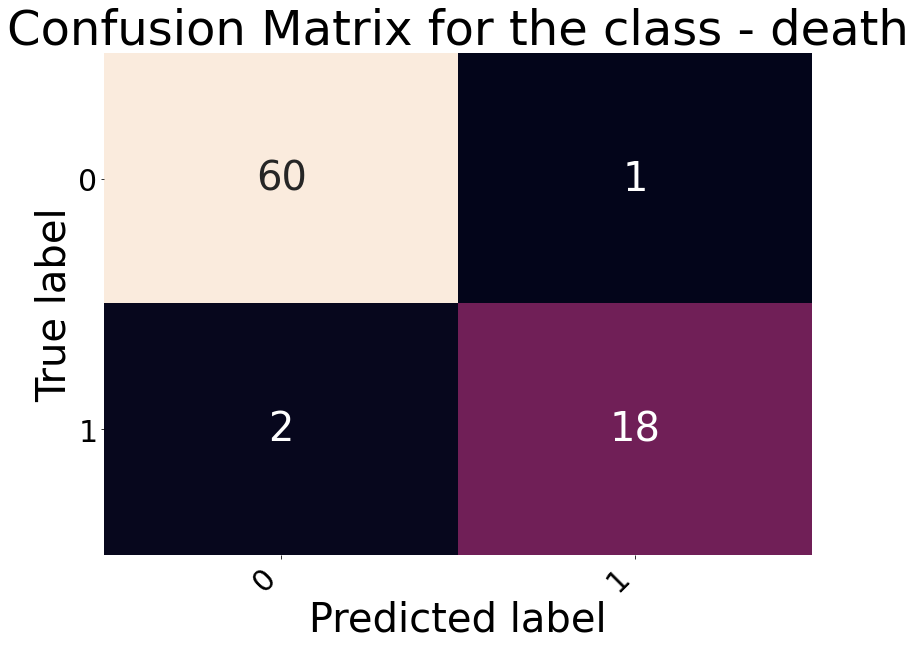

In [110]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[0], ax, action_values[0], ["0", "1"])
fig.tight_layout()
plt.show()

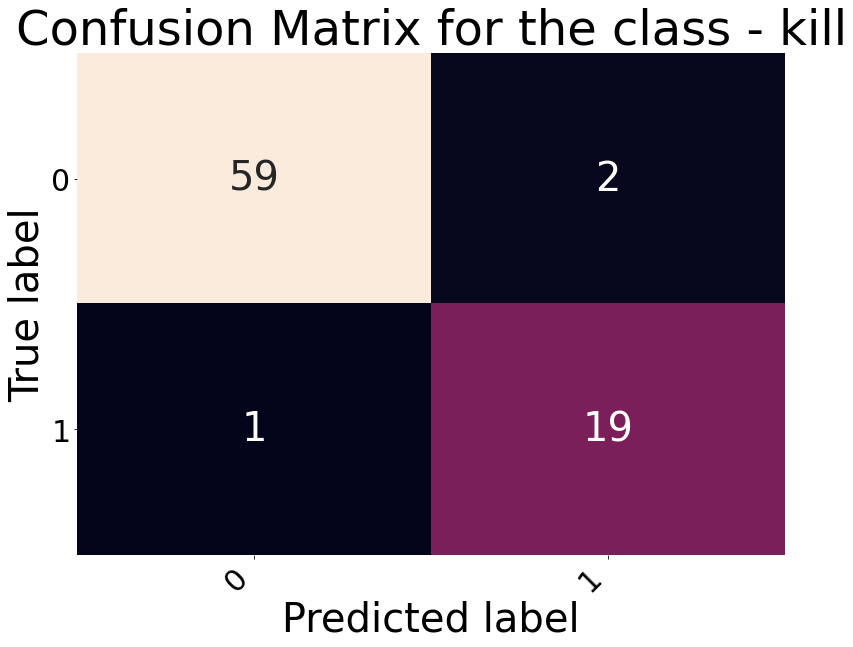

In [111]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[1], ax, action_values[1], ["0", "1"])
fig.tight_layout()
plt.show()

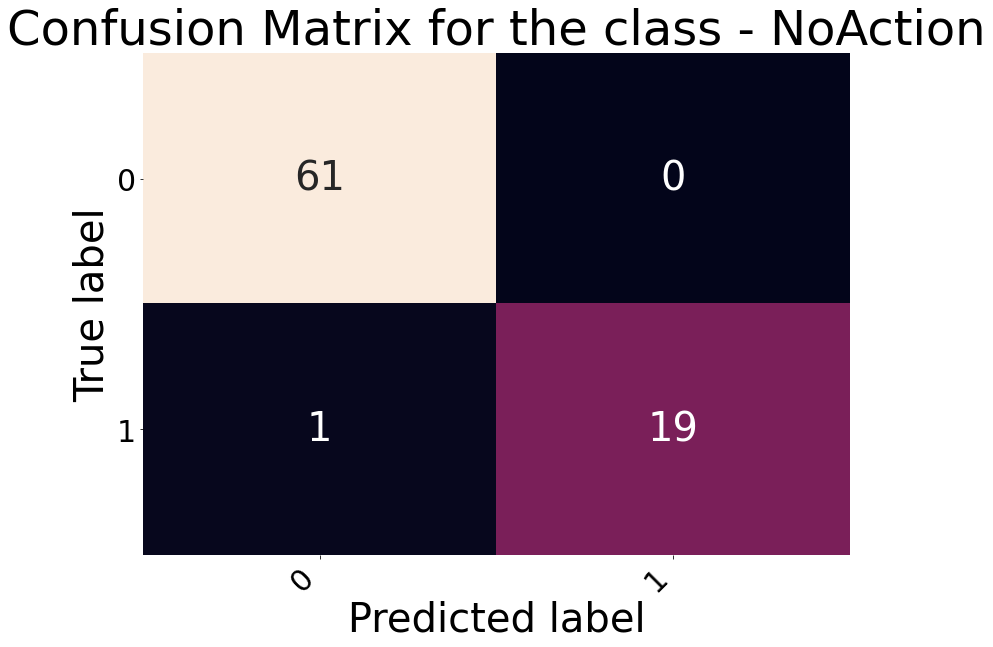

In [112]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[2], ax, action_values[2], ["0", "1"])
fig.tight_layout()
plt.show()

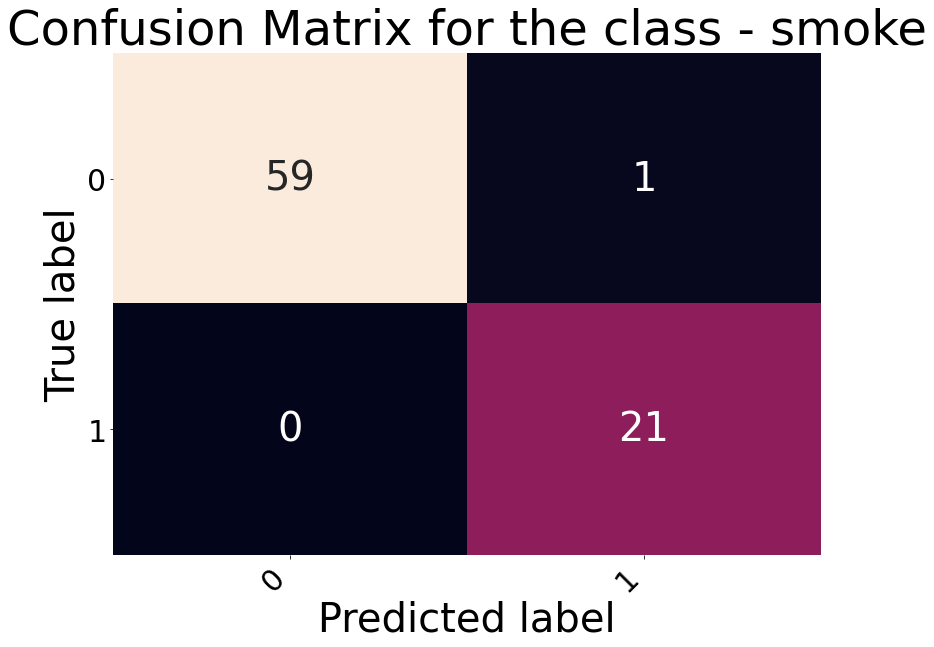

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[3], ax, action_values[3], ["0", "1"])
fig.tight_layout()
plt.show()

# Fault Data Identification

In [114]:
print(dict_xception)
print('')
print(dict_vgg16)
print('')
print(dict_inceptionv3)
print('')
print(dict_inceptionresnetv2)
print('')
print(dict_ResNet152V2)

{'death_17': 'kill', 'Kill_4': 'death', 'NoAction_102': 'kill', 'NoAction_9': 'smoke', 'death_55': 'smoke', 'NoAction_77': 'death', 'death_16': 'kill', 'Kill_89': 'smoke', 'smoke_7 ': 'kill'}

{'death_17': 'kill', 'Kill_4': 'NoAction', 'death_33': 'NoAction', 'NoAction_9': 'smoke', 'smoke_10 ': 'death', 'death_16': 'kill', 'Kill_89': 'NoAction'}

{'death_17': 'kill', 'Kill_4': 'smoke', 'NoAction_55': 'smoke', 'death_45': 'NoAction', 'NoAction_102': 'kill', 'NoAction_9': 'smoke', 'Kill_22': 'death', 'smoke_7 ': 'death'}

{'death_17': 'kill', 'death_37': 'kill', 'Kill_4': 'smoke', 'death_33': 'smoke', 'NoAction_55': 'kill', 'Kill_5': 'NoAction', 'death_42': 'smoke', 'death_102': 'kill', 'smoke_10 ': 'kill', 'smoke_25 ': 'NoAction', 'death_16': 'kill', 'death_66': 'NoAction', 'smoke_7 ': 'kill'}

{'death_17': 'kill', 'Kill_4': 'death', 'NoAction_9': 'smoke', 'death_16': 'kill'}


In [115]:
from collections import Counter

#key_list_vgg16 = list(dict_vgg16.keys())
key_list_xception = list(dict_xception.keys())
key_list_inceptionv3 = list(dict_inceptionv3.keys())
key_list_inceptionresnetv2 = list(dict_inceptionresnetv2.keys())
key_list_ResNet152V2 = list(dict_ResNet152V2.keys())


#key_list = key_list_vgg16 + key_list_xception + key_list_inceptionv3 + key_list_inceptionresnetv2 + key_list_ResNet152V2
key_list = key_list_xception + key_list_inceptionv3 + key_list_inceptionresnetv2 + key_list_ResNet152V2

print(Counter(key_list))

Counter({'death_17': 4, 'Kill_4': 4, 'NoAction_9': 3, 'death_16': 3, 'smoke_7 ': 3, 'NoAction_102': 2, 'NoAction_55': 2, 'death_55': 1, 'NoAction_77': 1, 'Kill_89': 1, 'death_45': 1, 'Kill_22': 1, 'death_37': 1, 'death_33': 1, 'Kill_5': 1, 'death_42': 1, 'death_102': 1, 'smoke_10 ': 1, 'smoke_25 ': 1, 'death_66': 1})


In [116]:
key_list_vgg16 = list(dict_vgg16.keys())
print(key_list_vgg16)

['death_17', 'Kill_4', 'death_33', 'NoAction_9', 'smoke_10 ', 'death_16', 'Kill_89']


In [117]:
from collections import Counter

key_list_vgg16 = list(dict_vgg16.keys())
key_list_xception = list(dict_xception.keys())
key_list_inceptionv3 = list(dict_inceptionv3.keys())
key_list_inceptionresnetv2 = list(dict_inceptionresnetv2.keys())
key_list_ResNet152V2 = list(dict_ResNet152V2.keys())


key_list = key_list_vgg16 + key_list_xception + key_list_inceptionv3 + key_list_inceptionresnetv2 + key_list_ResNet152V2

print(Counter(key_list))

Counter({'death_17': 5, 'Kill_4': 5, 'NoAction_9': 4, 'death_16': 4, 'smoke_7 ': 3, 'death_33': 2, 'smoke_10 ': 2, 'Kill_89': 2, 'NoAction_102': 2, 'NoAction_55': 2, 'death_55': 1, 'NoAction_77': 1, 'death_45': 1, 'Kill_22': 1, 'death_37': 1, 'Kill_5': 1, 'death_42': 1, 'death_102': 1, 'smoke_25 ': 1, 'death_66': 1})


# Majority voting

In [118]:
majority_predict = []

for i in range(len(predict_vgg16)):
    
    a = [predict_vgg16[i], predict_xception[i], predict_inception[i], predict_inceptionresnet[i], predict_resnet[i]]
    
    most_common_item = max(a, key = a.count)
    majority_predict.append(most_common_item)
    
print(majority_predict)
print(len(majority_predict))
print(accuracy_score(majority_predict, actual)*100)

['kill', 'smoke', 'NoAction', 'smoke', 'NoAction', 'kill', 'smoke', 'death', 'kill', 'death', 'NoAction', 'death', 'death', 'NoAction', 'NoAction', 'NoAction', 'death', 'smoke', 'kill', 'NoAction', 'death', 'NoAction', 'kill', 'smoke', 'NoAction', 'death', 'NoAction', 'kill', 'smoke', 'NoAction', 'kill', 'kill', 'kill', 'smoke', 'smoke', 'smoke', 'kill', 'kill', 'death', 'kill', 'NoAction', 'smoke', 'smoke', 'NoAction', 'death', 'kill', 'smoke', 'death', 'smoke', 'death', 'smoke', 'smoke', 'smoke', 'NoAction', 'death', 'NoAction', 'smoke', 'NoAction', 'NoAction', 'death', 'smoke', 'NoAction', 'kill', 'death', 'smoke', 'kill', 'death', 'death', 'kill', 'kill', 'kill', 'kill', 'death', 'smoke', 'death', 'kill', 'NoAction', 'smoke', 'smoke', 'kill', 'death']
81
95.06172839506173


In [119]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score

accuracy = accuracy_score(majority_predict, actual)*100
precision = precision_score(actual, majority_predict, average=None)
f1_score = f1_score(actual, majority_predict, average=None)
recall = recall_score(actual, majority_predict, average=None)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('F1_score: ', f1_score)
print('Recall: ', recall)

Accuracy:  95.06172839506173
Precision:  [1.         0.94736842 0.9047619  0.95454545]
F1_score:  [0.97435897 0.92307692 0.92682927 0.97674419]
Recall:  [0.95 0.9  0.95 1.  ]


In [120]:
confusion_matrix = multilabel_confusion_matrix(actual, majority_predict, labels=action_values)

print(confusion_matrix)

[[[60  1]
  [ 2 18]]

 [[59  2]
  [ 1 19]]

 [[61  0]
  [ 1 19]]

 [[59  1]
  [ 0 21]]]


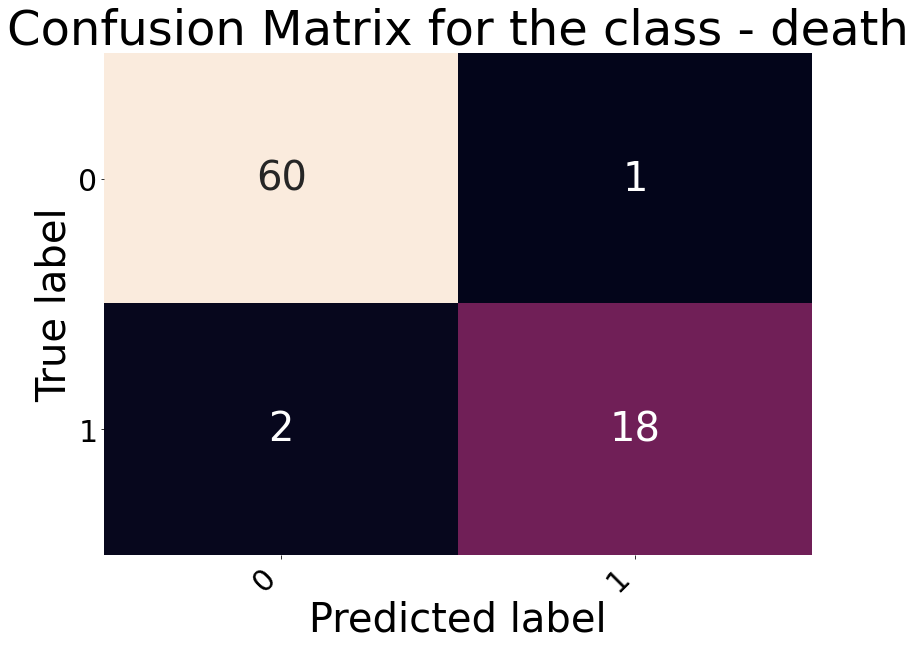

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[0], ax, action_values[0], ["0", "1"])
fig.tight_layout()
plt.show()

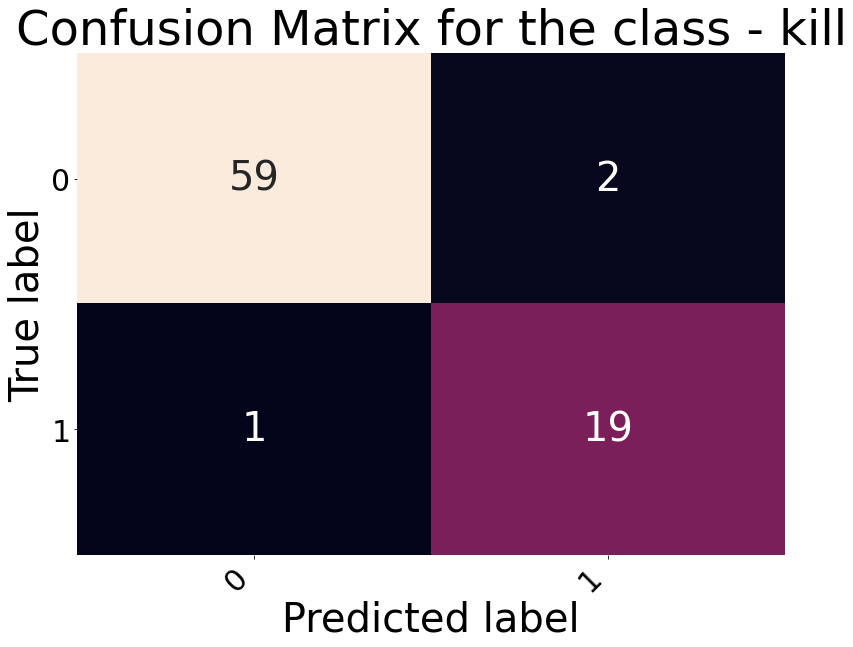

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[1], ax, action_values[1], ["0", "1"])
fig.tight_layout()
plt.show()

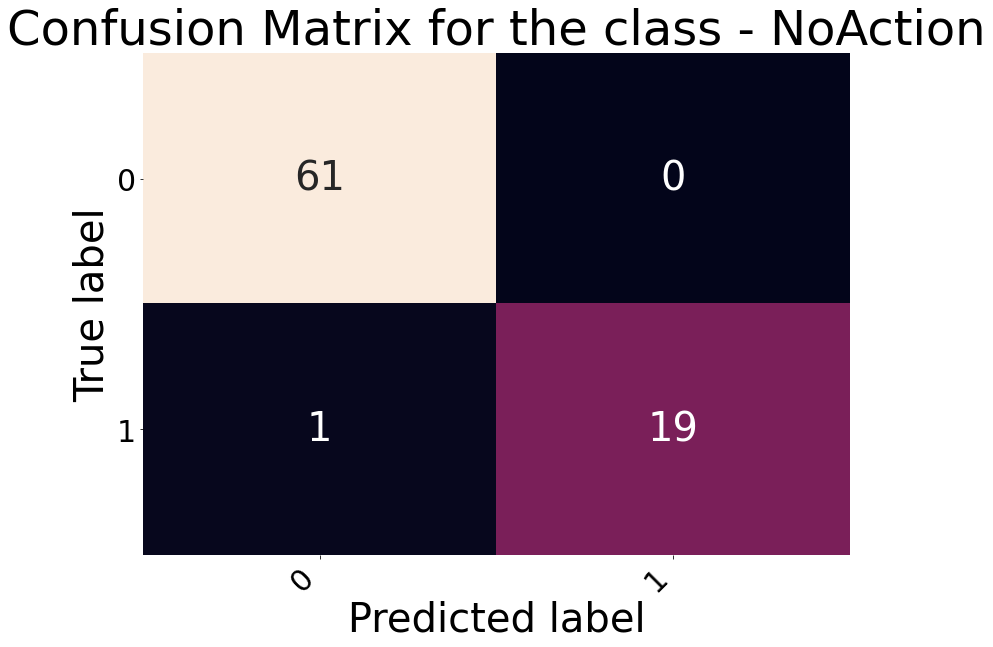

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[2], ax, action_values[2], ["0", "1"])
fig.tight_layout()
plt.show()

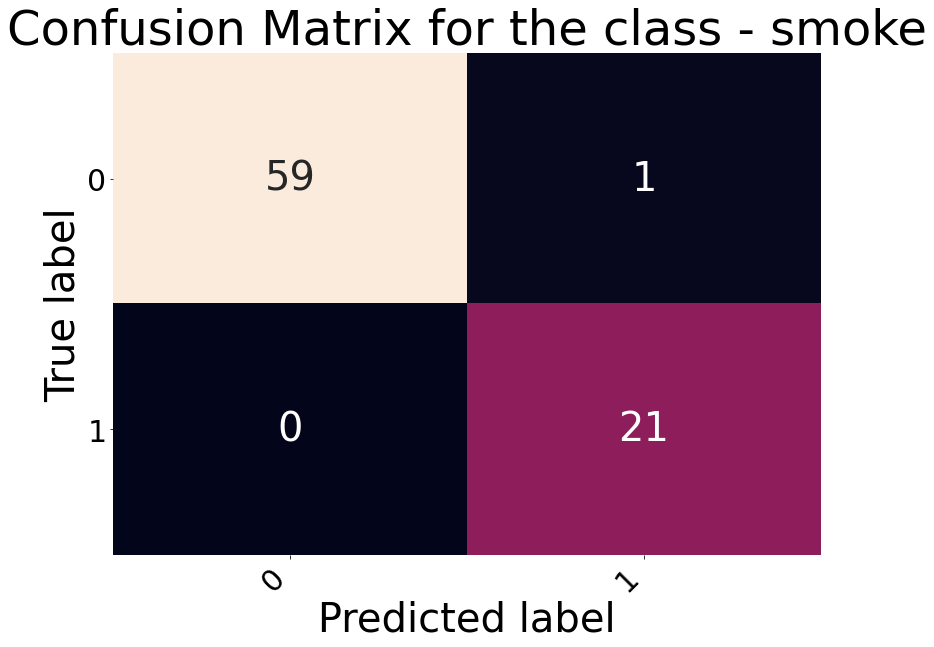

In [128]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
plt.rcParams.update({'font.size': 40})
print_confusion_matrix(confusion_matrix[3], ax, action_values[3], ["0", "1"])
fig.tight_layout()
plt.show()

# Model of Each Tranfer Learning

In [108]:
#vgg16
model_vgg16 = Sequential()
model_vgg16.add(Dense(512, activation='relu', input_shape=(25088,)))
model_vgg16.add(Dropout(0.5))
#model_vgg16.add(Dense(512, activation='relu'))
#model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(256, activation='relu'))
model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
#model_vgg16.add(Dense(64, activation='relu'))
#model_vgg16.add(Dropout(0.5))
model_vgg16.add(Dense(4, activation='softmax'))
model_vgg16.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
#model_vgg16.summary()

#xception
model_xception = Sequential()
model_xception.add(Dense(512, activation='relu', input_shape=(100352,)))
model_xception.add(Dropout(0.5))
#model_xception.add(Dense(512, activation='relu'))
#model_xception.add(Dropout(0.5))
model_xception.add(Dense(256, activation='relu'))
model_xception.add(Dropout(0.5))
model_xception.add(Dense(128, activation='relu'))
model_xception.add(Dropout(0.5))
model_xception.add(Dense(4, activation='softmax'))
model_xception.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
#model_xception.summary()

#inception
model_inception = Sequential()
model_inception.add(Dense(1024, activation='relu', input_shape=(51200,)))
model_inception.add(Dropout(0.5))
model_inception.add(Dense(512, activation='relu'))
model_inception.add(Dropout(0.5))
model_inception.add(Dense(256, activation='relu'))
model_inception.add(Dropout(0.5))
model_inception.add(Dense(128, activation='relu'))
model_inception.add(Dropout(0.5))
model_inception.add(Dense(4, activation='softmax'))
model_inception.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
#model_inception.summary()

#inception_resnet_v2
model_inception_resnet_v2 = Sequential()
model_inception_resnet_v2.add(Dense(512, activation='relu', input_shape=(38400,)))
model_inception_resnet_v2.add(Dropout(0.5))
#model_inception_resnet_v2.add(Dense(512, activation='relu'))
#model_inception_resnet_v2.add(Dropout(0.5))
model_inception_resnet_v2.add(Dense(256, activation='relu'))
model_inception_resnet_v2.add(Dropout(0.5))
model_inception_resnet_v2.add(Dense(128, activation='relu'))
model_inception_resnet_v2.add(Dropout(0.5))
model_inception_resnet_v2.add(Dense(4, activation='softmax'))
model_inception_resnet_v2.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
#model_inception_resnet_v2.summary()

#resnet_v2
model_resnet_v2 = Sequential()
model_resnet_v2.add(Dense(512, activation='relu', input_shape=(100352,)))
model_resnet_v2.add(Dropout(0.5))
#model_resnet_v2.add(Dense(512, activation='relu'))
#model_resnet_v2.add(Dropout(0.1))
model_resnet_v2.add(Dense(256, activation='relu'))
model_resnet_v2.add(Dropout(0.5))
model_resnet_v2.add(Dense(128, activation='relu'))
model_resnet_v2.add(Dropout(0.5))
#model_resnet_v2.add(Dense(64, activation='relu'))
#model_resnet_v2.add(Dropout(0.5))
#model_resnet_v2.add(Dense(32, activation='relu'))
#model_resnet_v2.add(Dropout(0.5))
model_resnet_v2.add(Dense(4, activation='softmax'))
model_resnet_v2.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
#model_resnet_v2.summary()